## 1. Line Noise Removal

* <b>CleanLineNoise</b> removes the line frequency (50 or 60 Hz) and harmonics that are multiples of the line frequency up to the Nyquist frequency.
    

In [1]:
import numpy as np
import ln_removal

# a. Reading in our ExG signal
## i. Tapping artifact
ExG_tap = np.transpose( np.genfromtxt("offline_exp_ExG-30s.csv", delimiter = ',') )
ExG_tap = ExG_tap[:, 1:]
# timestamps start at 0 s
ExG_tap[0] = ExG_tap[0] - ExG_tap[0][0]

## ii. Blinking artifact
ExG_blink = np.transpose( np.genfromtxt("blinking-artifact_ExG.csv", delimiter = ',') )
ExG_blink = ExG_blink[:, 1:]
# timestamps start at 0 s
ExG_blink[0] = ExG_blink[0] - ExG_blink[0][0]

## iii. Movement artifact
ExG_mov = np.transpose( np.genfromtxt("movement-artifact_ExG.csv", delimiter = ',') )
ExG_mov = ExG_mov[:, 1:]
# timestamps start at 0 s
ExG_mov[0] = ExG_mov[0] - ExG_mov[0][0]

s_rate = 250 # Sampling rate = 250 Hz
ln_freq = 50 # Line frequency = 50 Hz


# b. Adding components at the line frequency + harmonics and frequencies > 100 Hz
## i. Noisy signal: Tapping artifact
dt_tap = ExG_tap[0][1] - ExG_tap[0][0]
t_tap = ExG_tap[0]
line_sig_tap = 20 * ( np.sin(2*np.pi*50*t_tap) + np.sin(2*np.pi*100*t_tap) + np.sin(2*np.pi*120*t_tap) )
ExG_tap_sig = ExG_tap
ExG_tap_sig[1:] = ExG_tap[1:] + line_sig_tap
## ii. Noisy signal: Blinking artifact
dt_blink = ExG_blink[0][1] - ExG_blink[0][0]
t_blink = ExG_blink[0]
line_sig_blink = 20 * ( np.sin(2*np.pi*50*t_blink) + np.sin(2*np.pi*100*t_blink) + np.sin(2*np.pi*120*t_blink) )
ExG_blink_sig = ExG_blink
ExG_blink_sig[1:] = ExG_blink[1:] + line_sig_blink
## iii. Noisy signal: Movement artifact
dt_mov = ExG_mov[0][1] - ExG_mov[0][0]
t_mov = ExG_mov[0]
line_sig_mov = 20 * ( np.sin(2*np.pi*50*t_mov) + np.sin(2*np.pi*100*t_mov) + np.sin(2*np.pi*120*t_mov) )
ExG_mov_sig = ExG_mov
ExG_mov_sig[1:] = ExG_mov[1:] + line_sig_mov


#       Computing Fourier Transform
def compute_fft(t: np.array, signal: np.array):
    n = len(t)
    dt = t[1] - t[0]
    freq = (1/(dt*n)) * np.arange(n)                            # frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32)     # first half index
    fhat = np.fft.fft(signal)                                   # computes the fft
    psd = fhat * np.conj(fhat)/n
    return([freq, idxs_half, psd])
## i. Noisy signal: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_sig] = compute_fft(t_tap, ExG_tap_sig[1])
## ii. Noisy signal: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_sig] = compute_fft(t_blink, ExG_blink_sig[1])
## iii. Noisy signal: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_sig] = compute_fft(t_mov, ExG_mov_sig[1]) 


# c. Removing the line noise
## i. LN removed: Tapping artifact
ExG_tap_lnrm = ln_removal.clean_ln_ch(ExG_tap_sig[1, :], ln_freq, s_rate)
#   include the timestamps
tmp = ExG_tap_sig[0, :]
ExG_tap_lnrm = np.transpose( np.c_[tmp, np.transpose(ExG_tap_lnrm)] )

## ii. LN removed: Blinking artifact
ExG_blink_lnrm = ln_removal.clean_ln_ch(ExG_blink_sig[1, :], ln_freq, s_rate)
#   include the timestamps
tmp = ExG_blink_sig[0, :]
ExG_blink_lnrm = np.transpose( np.c_[tmp, np.transpose(ExG_blink_lnrm)] )

## iii. LN removed: Movement artifact
ExG_mov_lnrm = ln_removal.clean_ln_ch(ExG_mov_sig[1, :], ln_freq, s_rate)
#   include the timestamps
tmp = ExG_mov_sig[0, :]
ExG_mov_lnrm = np.transpose( np.c_[tmp, np.transpose(ExG_mov_lnrm)] )


#       Computing Fourier Transform
## i. LN removed: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_lnrm] = compute_fft(t_tap, ExG_tap_lnrm[1])
## ii. LN removed: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_lnrm] = compute_fft(t_blink, ExG_blink_lnrm[1])
## iii. LN removed: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_lnrm] = compute_fft(t_mov, ExG_mov_lnrm[1])


Removed notch frequencies (Hz):
     50.00 :   14 windows
    100.00 :   14 windows
Removed notch frequencies (Hz):
     50.00 :   13 windows
    100.00 :   13 windows
Removed notch frequencies (Hz):
     50.00 :   13 windows
    100.00 :   13 windows


#### (i) Tapping Artifact

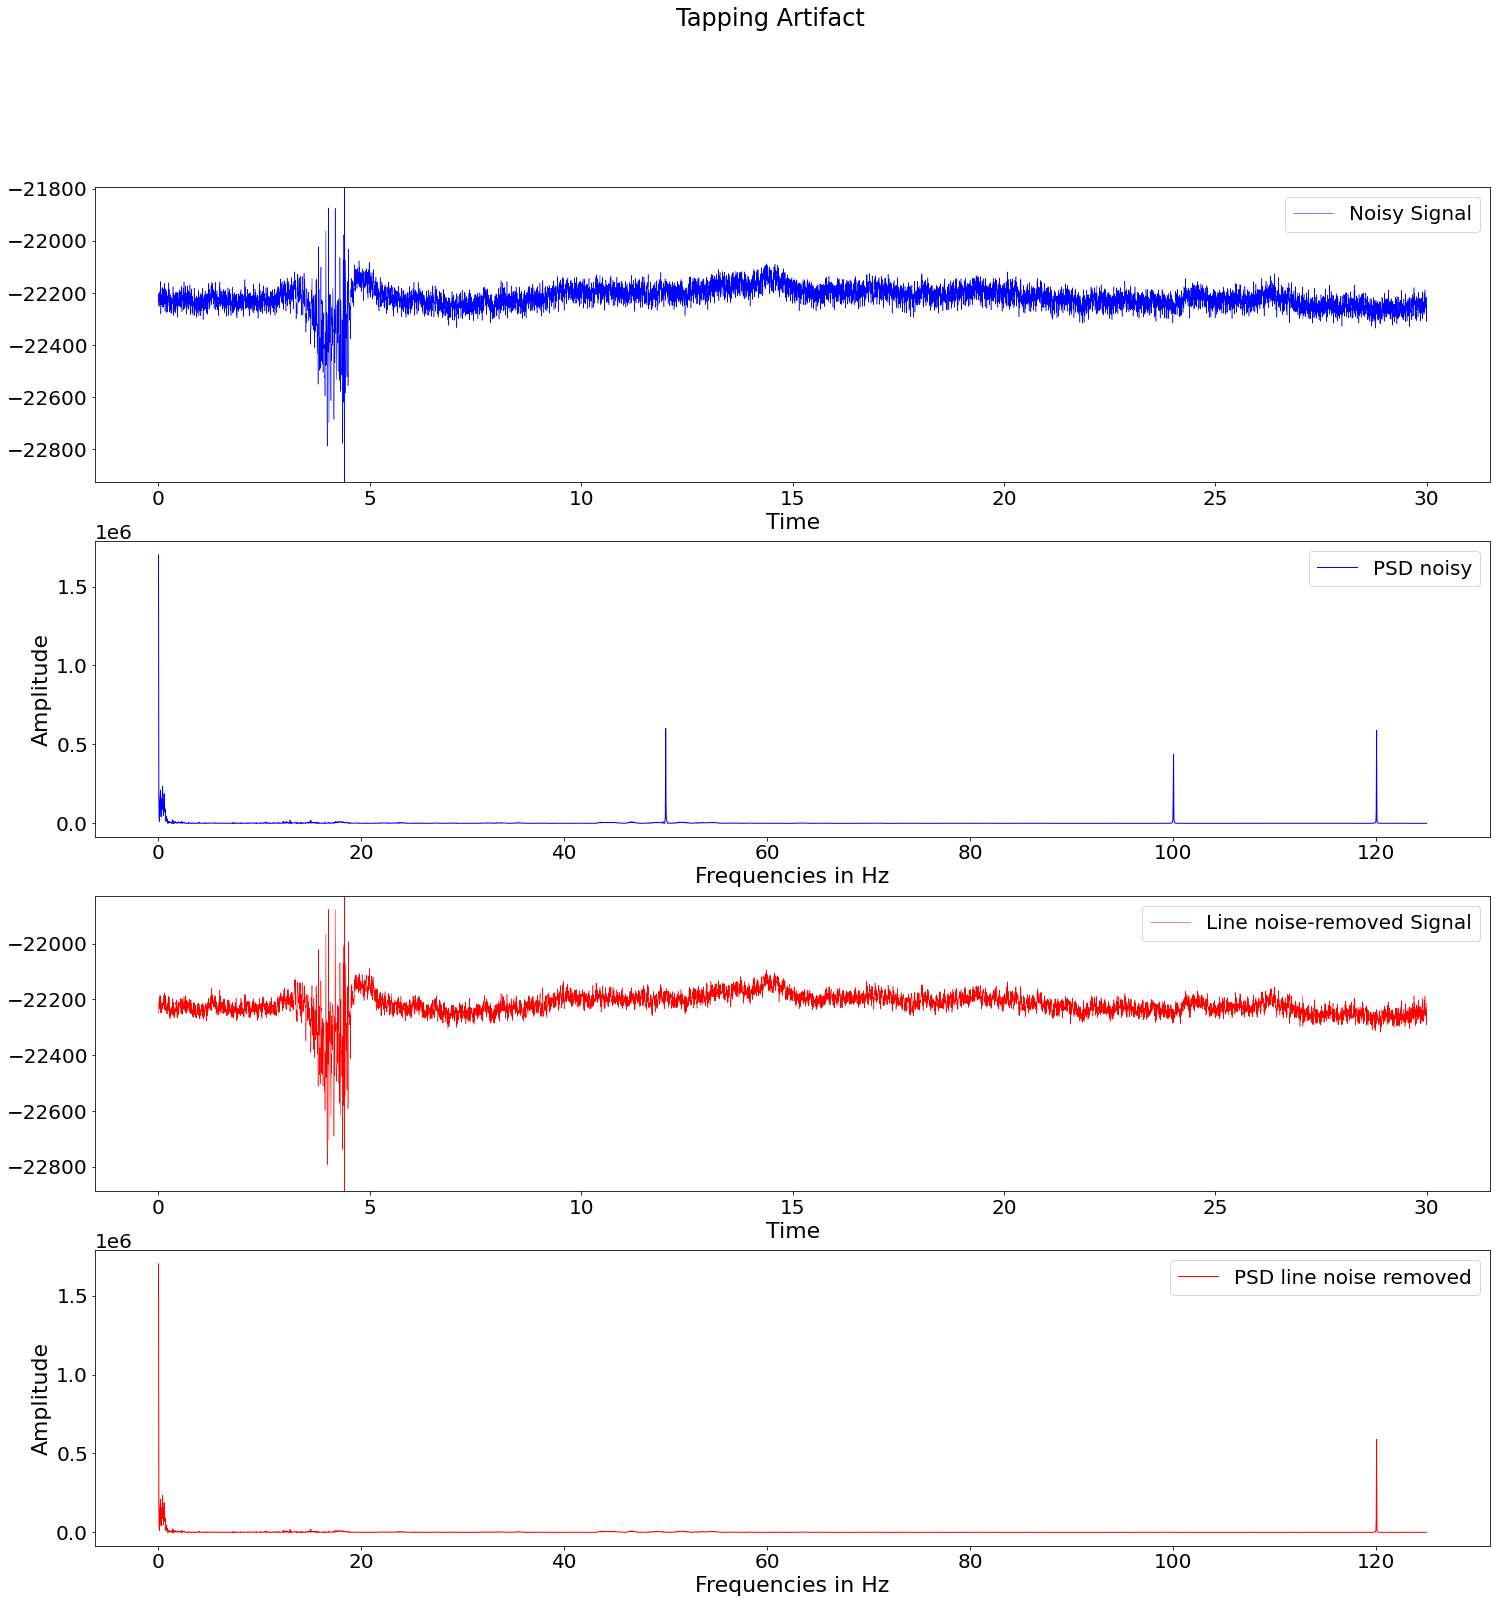

In [3]:
import matplotlib.pyplot as plt

# d. Plotting the spectrum before and after the Line noise removal
plt.rcParams['figure.figsize'] = [25, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)     # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)   # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)     # fontsize of the x and y labels 

fig, ax = plt.subplots(4,1)
ax[0].plot(t_tap, ExG_tap_sig[1], color='b', lw=0.5, label='Noisy Signal')
ax[0].set_ylim([ExG_tap_sig[1].min(), ExG_tap_sig[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_tap[idxs_half_tap], np.abs(psd_tap_sig[idxs_half_tap]), color='b', lw=1, label='PSD noisy')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t_tap, ExG_tap_lnrm[1], color='r', lw=0.5, label='Line noise-removed Signal')
ax[2].set_ylim([ExG_tap_lnrm[1].min(), ExG_tap_lnrm[1].max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_tap[idxs_half_tap], np.abs(psd_tap_lnrm[idxs_half_tap]), color='r', lw=1, label='PSD line noise removed')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.suptitle('Tapping Artifact')
plt.show()

#### (ii) Blinking Artifact

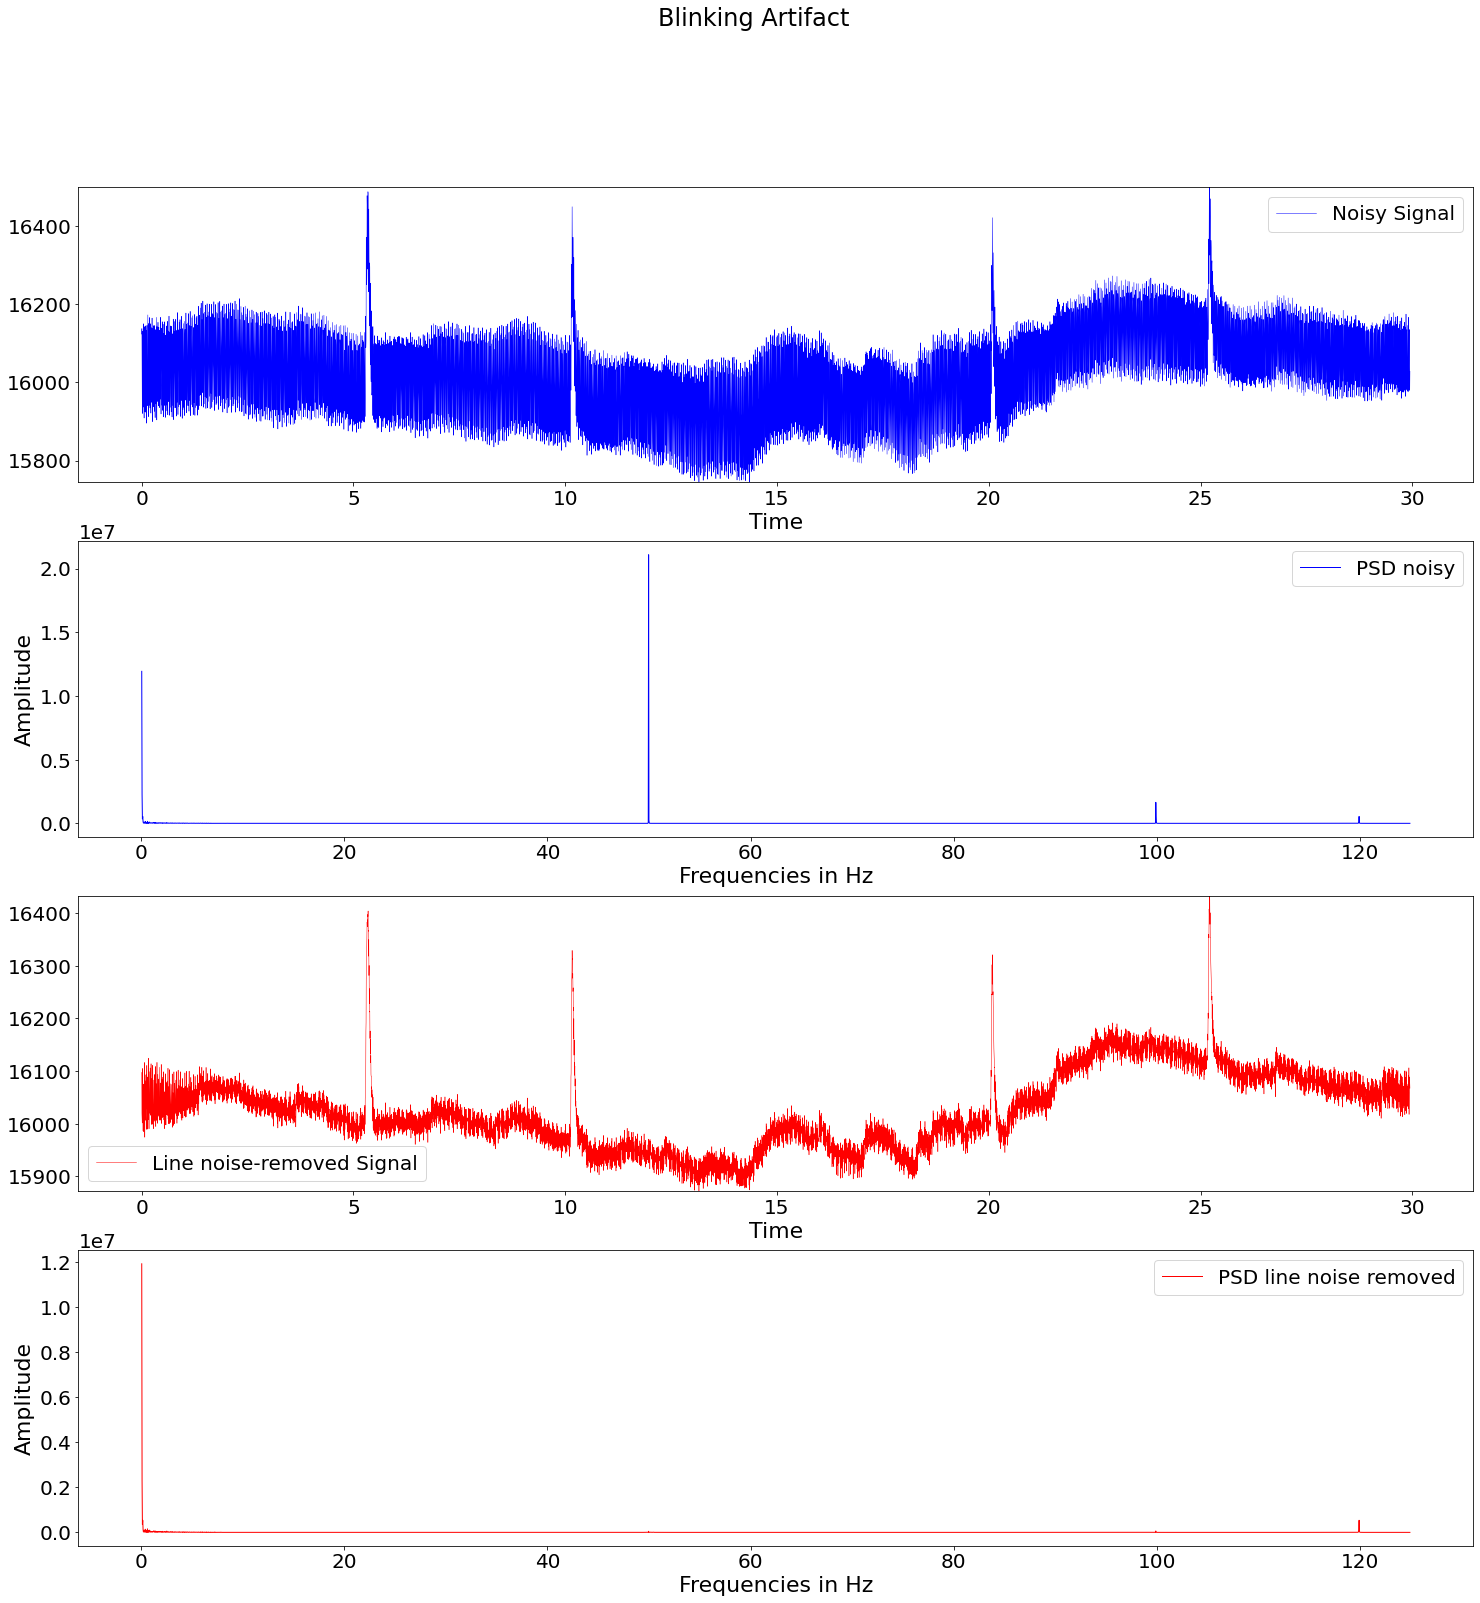

In [4]:
# d. Plotting the spectrum before and after the Line noise removal
fig, ax = plt.subplots(4,1)
ax[0].plot(t_blink, ExG_blink_sig[1], color='b', lw=0.5, label='Noisy Signal')
ax[0].set_ylim([ExG_blink_sig[1].min(), ExG_blink_sig[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_blink[idxs_half_blink], np.abs(psd_blink_sig[idxs_half_blink]), color='b', lw=1, label='PSD noisy')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t_blink, ExG_blink_lnrm[1], color='r', lw=0.5, label='Line noise-removed Signal')
ax[2].set_ylim([ExG_blink_lnrm[1].min(), ExG_blink_lnrm[1].max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_blink[idxs_half_blink], np.abs(psd_blink_lnrm[idxs_half_blink]), color='r', lw=1, label='PSD line noise removed')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.suptitle('Blinking Artifact')
plt.show()

#### (iii) Movement Artifact

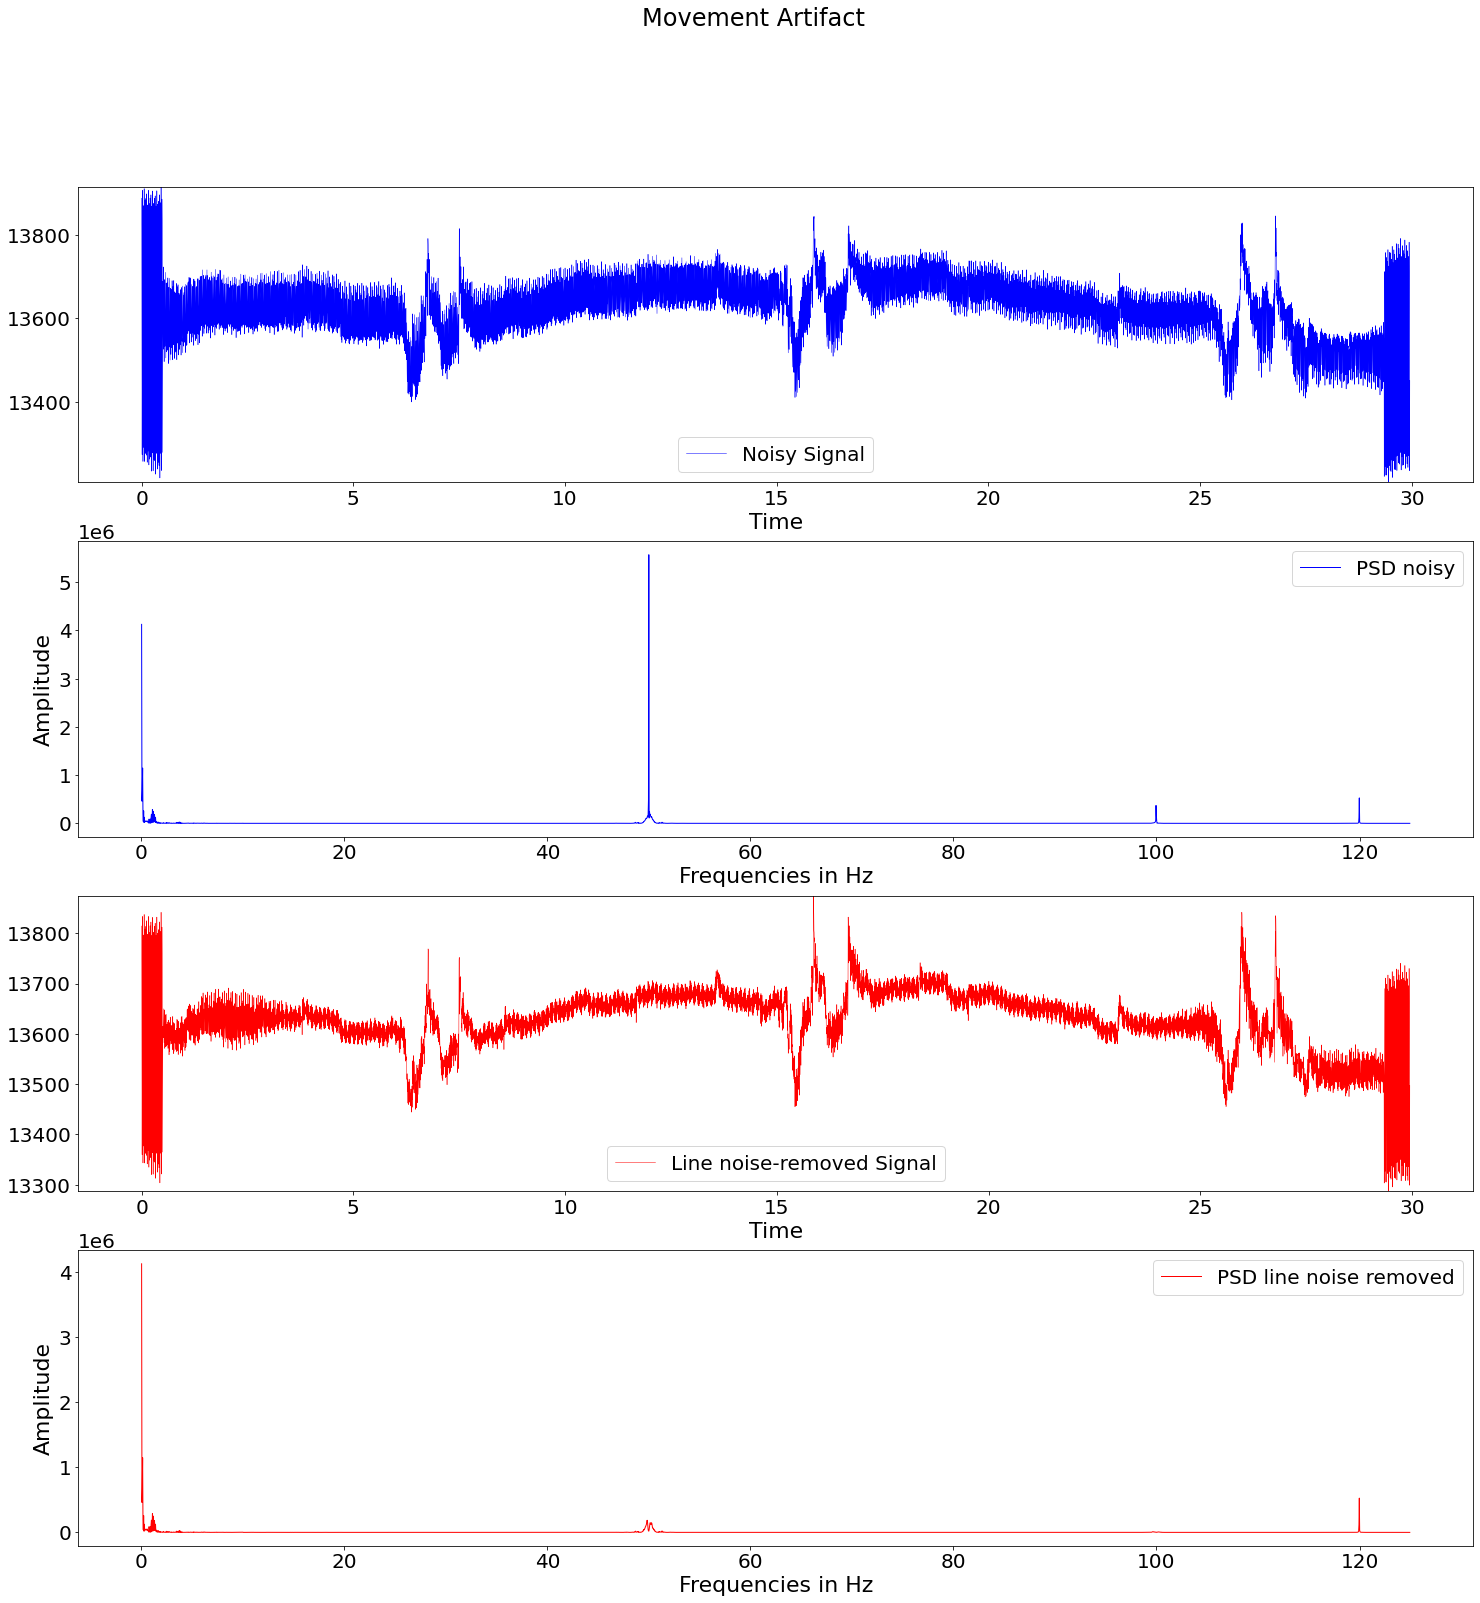

In [5]:
# d. Plotting the spectrum before and after the Line noise removal
fig, ax = plt.subplots(4,1)
ax[0].plot(t_mov, ExG_mov_sig[1], color='b', lw=0.5, label='Noisy Signal')
ax[0].set_ylim([ExG_mov_sig[1].min(), ExG_mov_sig[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_mov[idxs_half_mov], np.abs(psd_mov_sig[idxs_half_mov]), color='b', lw=1, label='PSD noisy')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t_blink, ExG_mov_lnrm[1], color='r', lw=0.5, label='Line noise-removed Signal')
ax[2].set_ylim([ExG_mov_lnrm[1].min(), ExG_mov_lnrm[1].max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_mov[idxs_half_mov], np.abs(psd_mov_lnrm[idxs_half_mov]), color='r', lw=1, label='PSD line noise removed')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.suptitle('Movement Artifact')
plt.show()

## 2. Filtering
* Applying a lowpass filter at frequency 100 Hz

In [6]:
import filtering

# a. Filtering signal
## i. Filtered: Tapping artifact
ExG_tap_lpf = filtering.lp_filt_ch(ExG_tap_lnrm[1, :], s_rate=s_rate)
#   include the timestamps
tmp = ExG_tap_sig[0, :]
ExG_tap_lpf = np.transpose( np.c_[tmp, np.transpose(ExG_tap_lpf)] )

## ii. Filtered: Blinking artifact
ExG_blink_lpf = filtering.lp_filt_ch(ExG_blink_lnrm[1, :], s_rate=s_rate)
#   include the timestamps
tmp = ExG_blink_sig[0, :]
ExG_blink_lpf = np.transpose( np.c_[tmp, np.transpose(ExG_blink_lpf)] )

## iii. Filtered: Movement artifact
ExG_mov_lpf = filtering.lp_filt_ch(ExG_mov_lnrm[1, :], s_rate=s_rate)
#   include the timestamps
tmp = ExG_mov_sig[0, :]
ExG_mov_lpf = np.transpose( np.c_[tmp, np.transpose(ExG_mov_lpf)] )


#       Computing Fourier Transform
## i. Filtered: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_lpf] = compute_fft(t_tap, ExG_tap_lpf[1])
## ii. Filtered: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_lpf] = compute_fft(t_blink, ExG_blink_lpf[1])
## iii. Filtered: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_lpf] = compute_fft(t_mov, ExG_mov_lpf[1])


Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33 samples (0.132 sec)

Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33 samples (0.132 sec)

Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain 

#### (i) Tapping Artifact

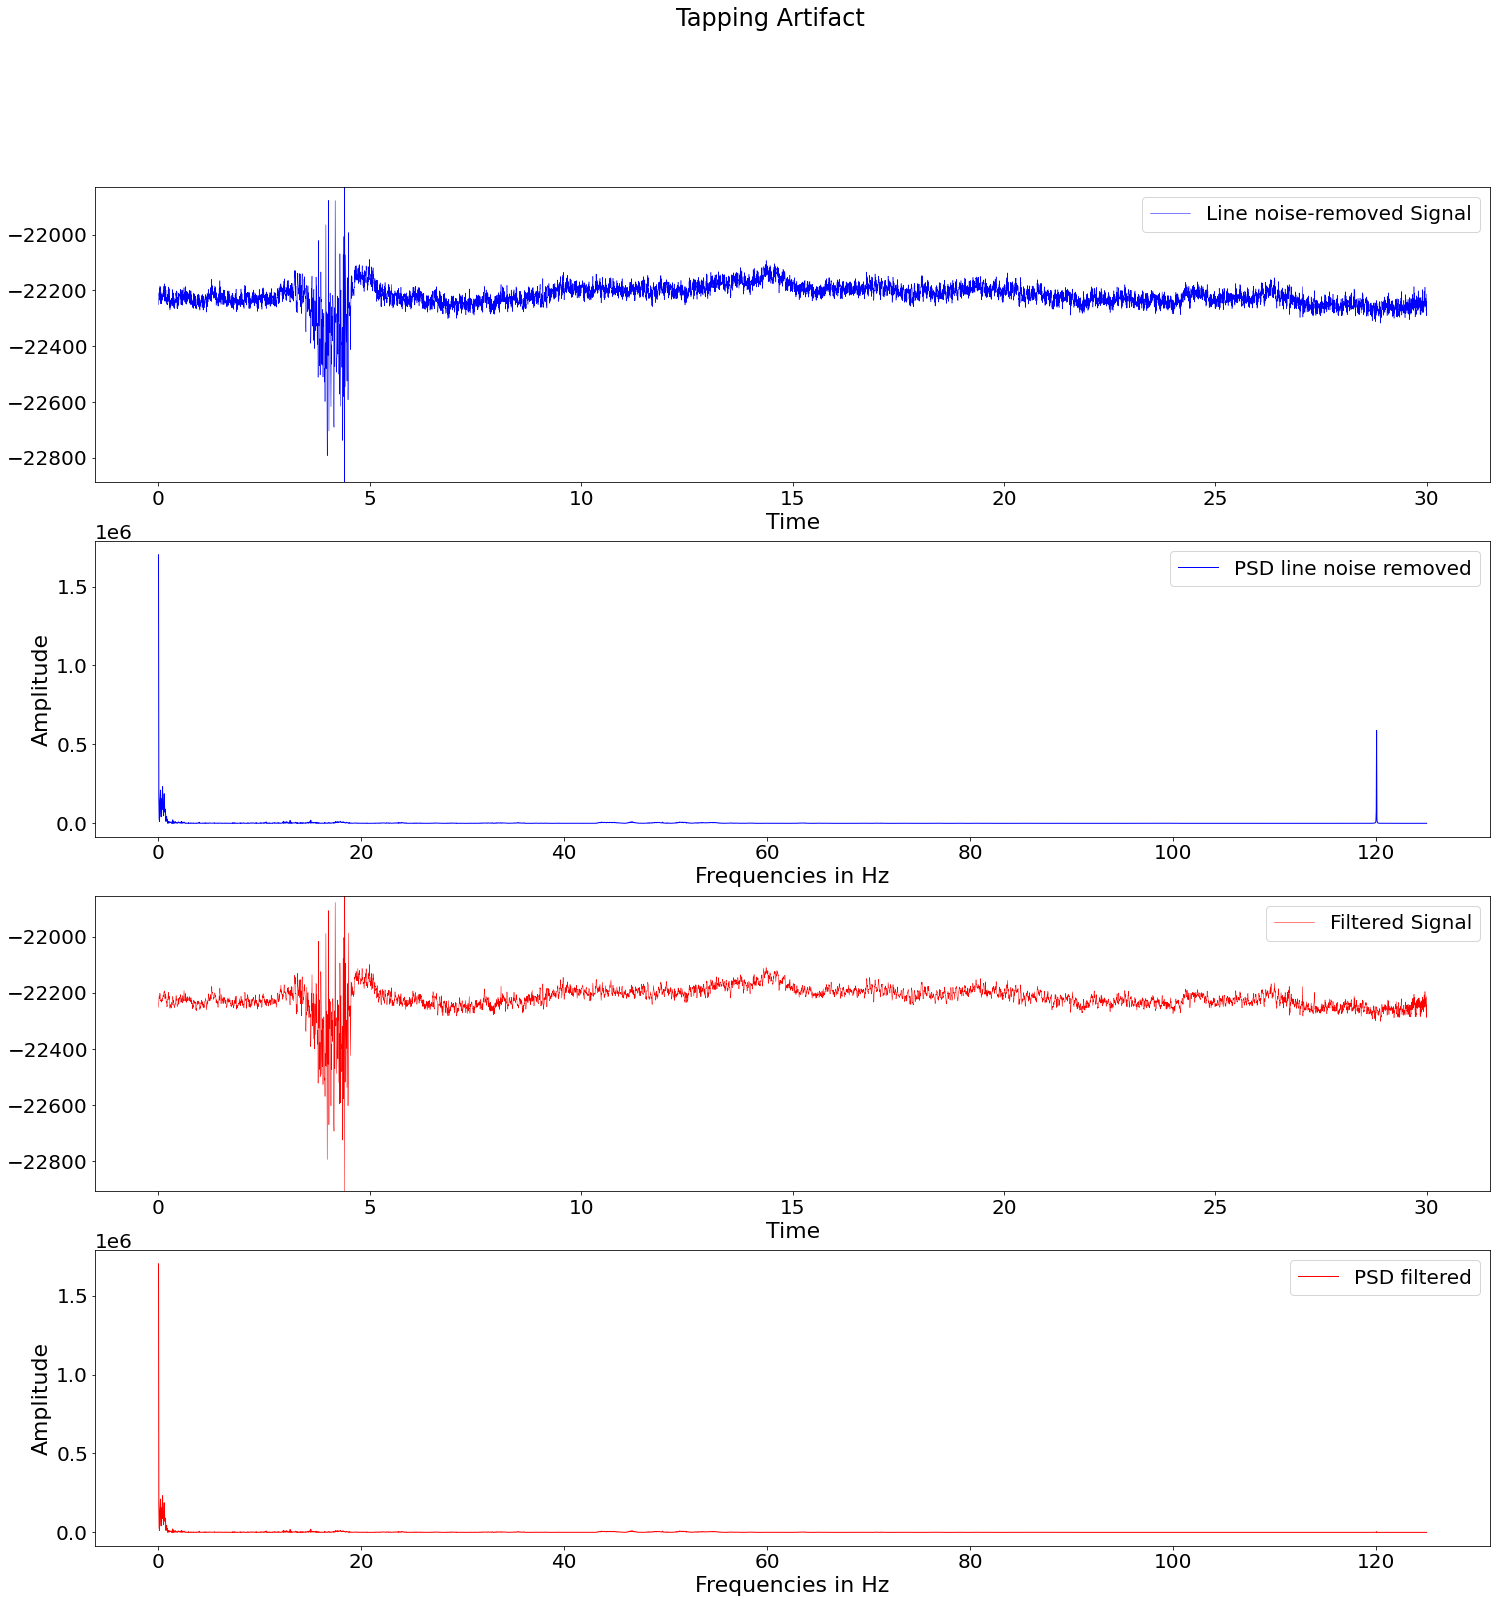

In [7]:
# b. Plotting the spectrum before and after Filtering
plt.rcParams['figure.figsize'] = [25, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)     # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)   # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)     # fontsize of the x and y labels 

fig, ax = plt.subplots(4,1)
ax[0].plot(t_tap, ExG_tap_lnrm[1], color='b', lw=0.5, label='Line noise-removed Signal')
ax[0].set_ylim([ExG_tap_lnrm[1].min(), ExG_tap_lnrm[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_tap[idxs_half_tap], np.abs(psd_tap_lnrm[idxs_half_tap]), color='b', lw=1, label='PSD line noise removed')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t_tap, ExG_tap_lpf[1], color='r', lw=0.5, label='Filtered Signal')
ax[2].set_ylim([ExG_tap_lpf[1].min(), ExG_tap_lpf[1].max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_tap[idxs_half_tap], np.abs(psd_tap_lpf[idxs_half_tap]), color='r', lw=1, label='PSD filtered')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.suptitle('Tapping Artifact')
plt.show()

#### (ii) Blinking Artifact

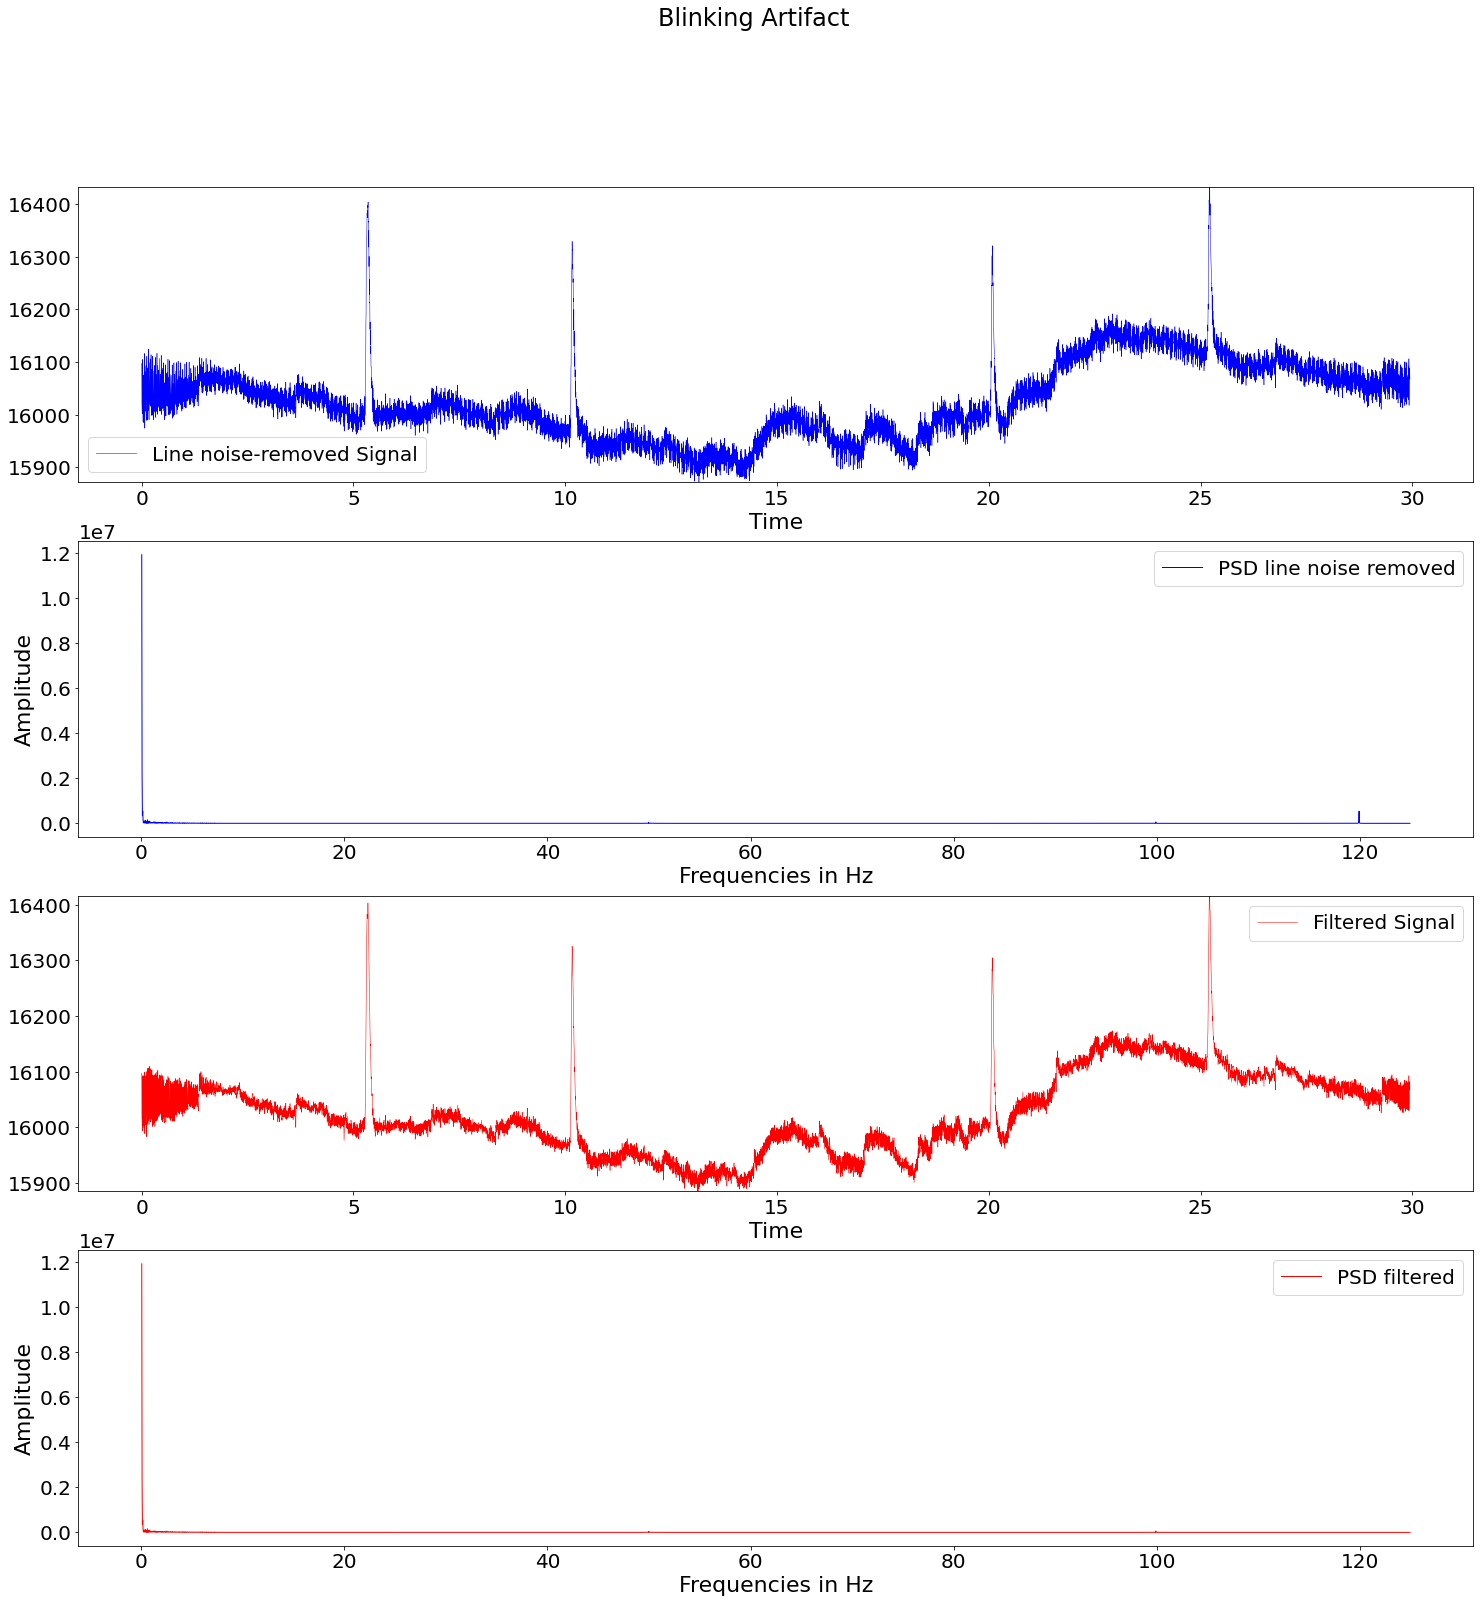

In [8]:
# b. Plotting the spectrum before and after Filtering
plt.rcParams['figure.figsize'] = [25, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)     # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)   # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)     # fontsize of the x and y labels 

fig, ax = plt.subplots(4,1)
ax[0].plot(t_blink, ExG_blink_lnrm[1], color='b', lw=0.5, label='Line noise-removed Signal')
ax[0].set_ylim([ExG_blink_lnrm[1].min(), ExG_blink_lnrm[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_blink[idxs_half_blink], np.abs(psd_blink_lnrm[idxs_half_blink]), color='b', lw=1, label='PSD line noise removed')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t_blink, ExG_blink_lpf[1], color='r', lw=0.5, label='Filtered Signal')
ax[2].set_ylim([ExG_blink_lpf[1].min(), ExG_blink_lpf[1].max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_blink[idxs_half_blink], np.abs(psd_blink_lpf[idxs_half_blink]), color='r', lw=1, label='PSD filtered')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.suptitle('Blinking Artifact')
plt.show()

#### (iii) Movement Artifact

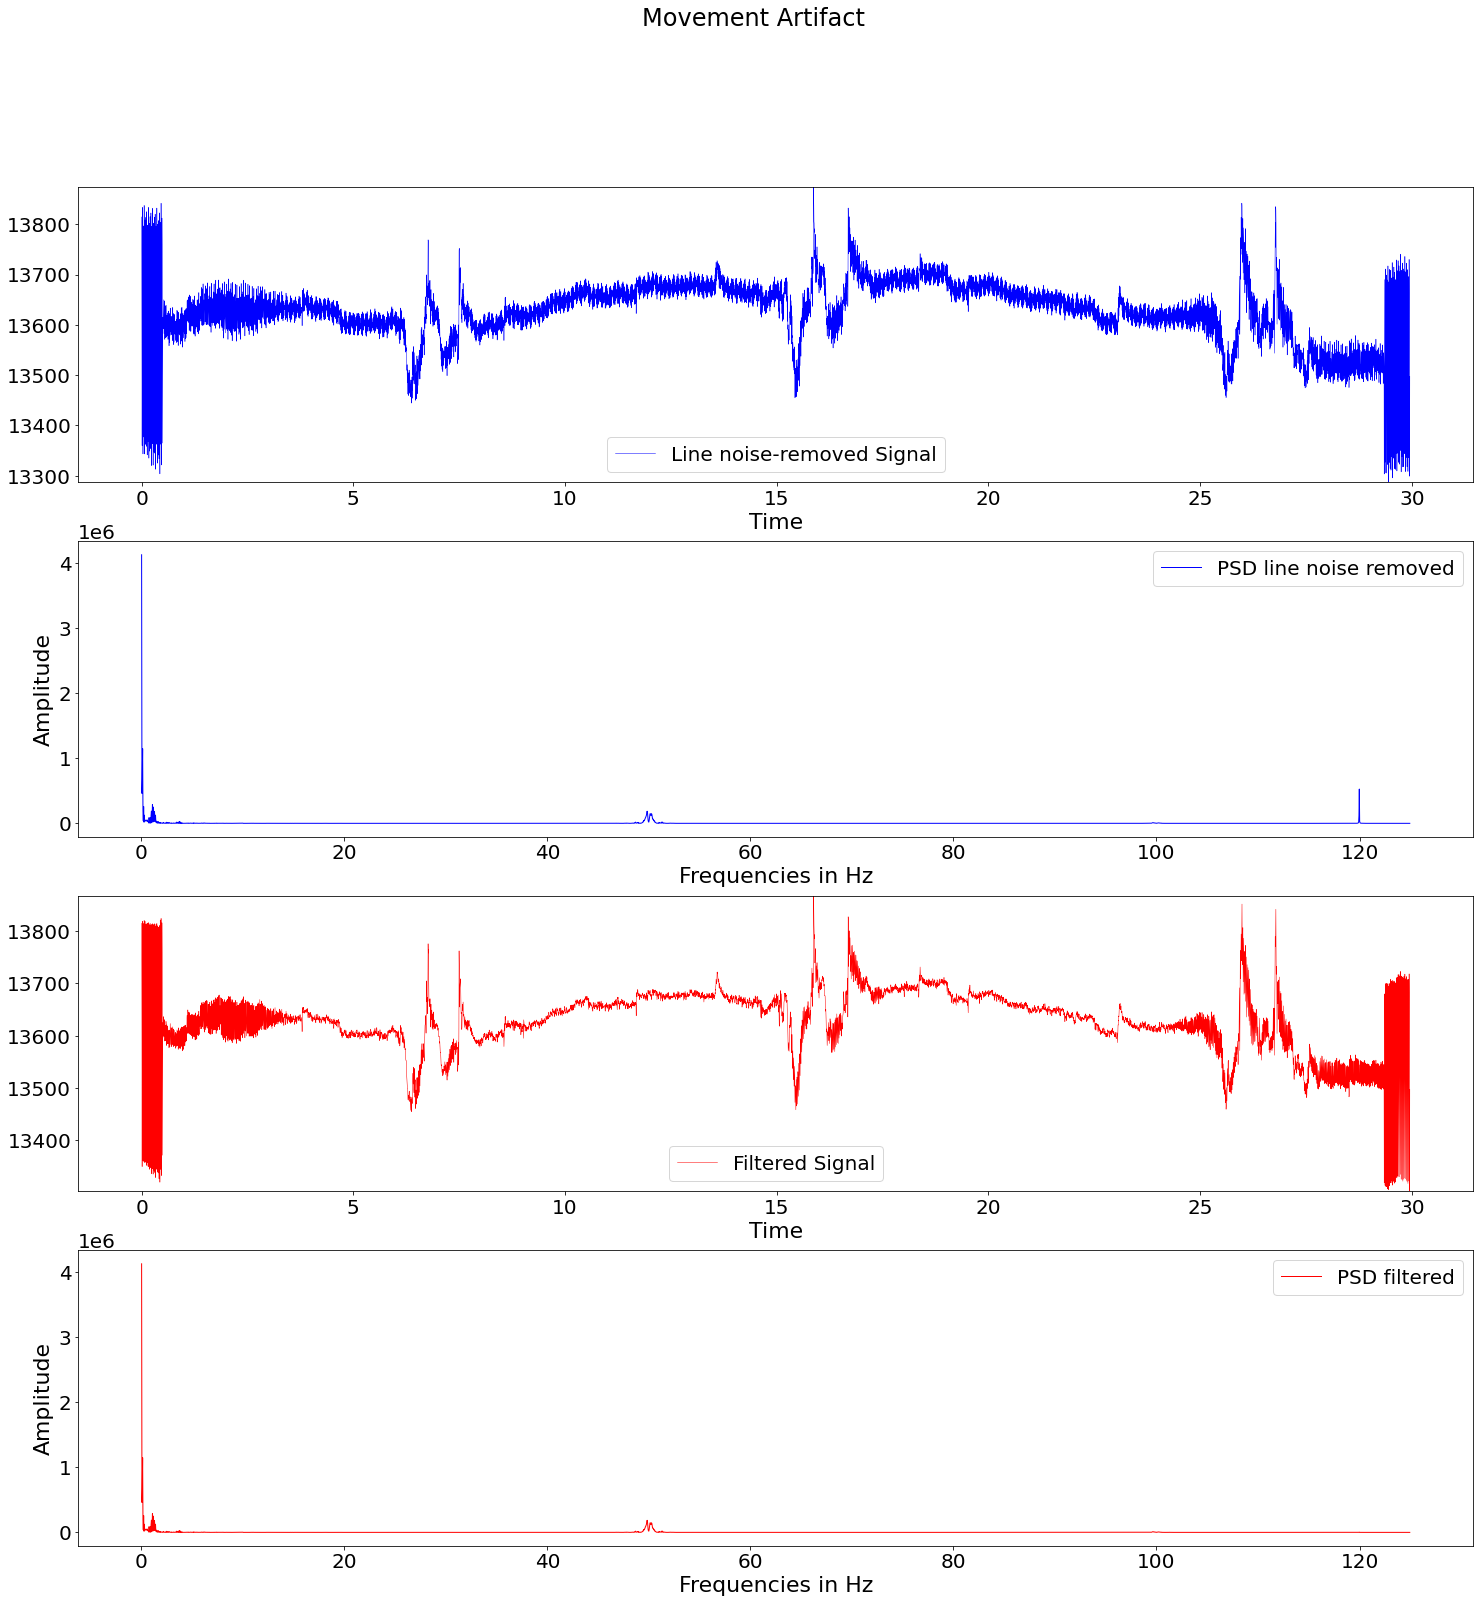

In [9]:
# b. Plotting the spectrum before and after Filtering
plt.rcParams['figure.figsize'] = [25, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)     # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)   # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)     # fontsize of the x and y labels 

fig, ax = plt.subplots(4,1)
ax[0].plot(t_mov, ExG_mov_lnrm[1], color='b', lw=0.5, label='Line noise-removed Signal')
ax[0].set_ylim([ExG_mov_lnrm[1].min(), ExG_mov_lnrm[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_mov[idxs_half_mov], np.abs(psd_mov_lnrm[idxs_half_mov]), color='b', lw=1, label='PSD line noise removed')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t_mov, ExG_mov_lpf[1], color='r', lw=0.5, label='Filtered Signal')
ax[2].set_ylim([ExG_mov_lpf[1].min(), ExG_mov_lpf[1].max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_mov[idxs_half_mov], np.abs(psd_mov_lpf[idxs_half_mov]), color='r', lw=1, label='PSD filtered')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.suptitle('Movement Artifact')
plt.show()

In [10]:
# Exporting filtered signal to process on MATLAB
## i. Tapping Artifact
np.savetxt('ExG_tap_lpf.csv', np.transpose(ExG_tap_lpf[1]), delimiter=",")
## ii. Blinking Artifact
np.savetxt('ExG_blink_lpf.csv', np.transpose(ExG_blink_lpf[1]), delimiter=",")
## iii. Movement Artifact
np.savetxt('ExG_mov_lpf.csv', np.transpose(ExG_mov_lpf[1]), delimiter=",")

## 3. Wavelet Thresholding
1. Wavelet Transform  
    * Each electrode’s time series is subjected to wavelet transform.
    * Chosen wavelet function: Coiflet order 4 (`coif4`)
    * Level of Data Decomposition:
        * if sampling rate > 500 Hz = `10`
        * if 250 Hz < sampling rate <= 500 Hz = `9`
        * if sampling rate <= 250 Hz = `8`
2. Determining threshold values for each level
    * Wavelet coefficients are then subjected to thresholding (in a `level-dependent` way)
    * The chosen method to determine these threshold values: `Bayes`   
    (I. M. Johnstone, B. W. Silverman (2005). [Empirical Bayes Selection of Wavelet Thresholds](https://arxiv.org/pdf/math/0508281.pdf)) 
3. Thresholding
    * Thresholding rule: `Hard`
4. Reconstruction
    * The resulting coefficients are reconstructed into a signal

### a. Bayes Thresholding

In [12]:
import numpy as np
import pywt
from wav_thd.ebayesthd_wav_dwt import ebayesthd_wav_dwt
import matplotlib.pyplot as plt 

"""
# a. Reading in our ExG signal
ExG_in = np.transpose( np.genfromtxt("offline_exp_ExG-30s.csv", delimiter = ',') )
ExG_in = ExG_in[:, 1:]
# timestamps start at 0 s
ExG_in[0] = ExG_in[0] - ExG_in[0][0]
s_rate = 250
ln_freq = 50 # Line frequency = 50 Hz

# Reading in filtered signal
ExG_filt = np.transpose( np.genfromtxt("ExG_filt.csv", delimiter = ',') )
"""

# a. Wavelet Tresholding
## i. Denoised: Tapping artifact
#   Wavelet thresholding 
artifacts_tap = ebayesthd_wav_dwt(ExG_tap_lpf[1, :], s_rate)
#   Denoised signal
ExG_tap_bayes = ExG_tap_lpf[1, :] - artifacts_tap
#   include the timestamps
tmp = ExG_tap_sig[0, :]
ExG_tap_bayes = np.transpose( np.c_[tmp, np.transpose(ExG_tap_bayes)] )

## ii. Denoised: Blinking artifact
#   Wavelet thresholding 
artifacts_blink = ebayesthd_wav_dwt(ExG_blink_lpf[1, :], s_rate)
#   Denoised signal
ExG_blink_bayes = ExG_blink_lpf[1, :] - artifacts_blink
#   include the timestamps
tmp = ExG_blink_sig[0, :]
ExG_blink_bayes = np.transpose( np.c_[tmp, np.transpose(ExG_blink_bayes)] )

## iii. Denoised: Movement artifact
#   Wavelet thresholding 
artifacts_mov = ebayesthd_wav_dwt(ExG_mov_lpf[1, :], s_rate)
#   Denoised signal
ExG_mov_bayes = ExG_mov_lpf[1, :] - artifacts_mov
#   include the timestamps
tmp = ExG_mov_sig[0, :]
ExG_mov_bayes = np.transpose( np.c_[tmp, np.transpose(ExG_mov_bayes)] )


#       Computing Fourier Transform
## i. Denoised: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_bayes] = compute_fft(t_tap, ExG_tap_bayes[1])
## ii. Denoised: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_bayes] = compute_fft(t_blink, ExG_blink_bayes[1])
## iii. Denoised: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_bayes] = compute_fft(t_mov, ExG_mov_bayes[1])

In [13]:
# Reading in results from MATLAB
ExG_tap_bayes_m = np.transpose( np.genfromtxt("ExG_tap_bayes_m.csv", delimiter = ',') )
ExG_blink_bayes_m = np.transpose( np.genfromtxt("ExG_blink_bayes_m.csv", delimiter = ',') )
ExG_mov_bayes_m = np.transpose( np.genfromtxt("ExG_mov_bayes_m.csv", delimiter = ',') )


#       Computing Fourier Transform
## i. Denoised on MATLAB: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_bayes_m] = compute_fft(t_tap, ExG_tap_bayes_m)
## ii. Denoised on MATLAB: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_bayes_m] = compute_fft(t_blink, ExG_blink_bayes_m)
## iii. Denoised on MATLAB: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_bayes_m] = compute_fft(t_mov, ExG_mov_bayes_m)


# Comparing both results by normalized cross correlation
# i. Tapping artifact
ExG_tap_bayes_norm = (ExG_tap_bayes[1] - np.mean(ExG_tap_bayes[1])) / (np.std(ExG_tap_bayes[1]) * len(ExG_tap_bayes[1]))
ExG_tap_bayes_m_norm = (ExG_tap_bayes_m - np.mean(ExG_tap_bayes_m)) / (np.std(ExG_tap_bayes_m))
c_tap = np.correlate(ExG_tap_bayes_norm, ExG_tap_bayes_m_norm)
print("Normalized cross correlation (tapping artifact):", c_tap)

# ii. Blinking artifact
ExG_blink_bayes_norm = (ExG_blink_bayes[1] - np.mean(ExG_blink_bayes[1])) / (np.std(ExG_blink_bayes[1]) * len(ExG_blink_bayes[1]))
ExG_blink_bayes_m_norm = (ExG_blink_bayes_m - np.mean(ExG_blink_bayes_m)) / (np.std(ExG_blink_bayes_m))
c_blink = np.correlate(ExG_blink_bayes_norm, ExG_blink_bayes_m_norm)
print("Normalized cross correlation (blinking artifact):", c_blink)

# iii. Movement artifact
ExG_mov_bayes_norm = (ExG_mov_bayes[1] - np.mean(ExG_mov_bayes[1])) / (np.std(ExG_mov_bayes[1]) * len(ExG_mov_bayes[1]))
ExG_mov_bayes_m_norm = (ExG_mov_bayes_m - np.mean(ExG_mov_bayes_m)) / (np.std(ExG_mov_bayes_m))
c_mov = np.correlate(ExG_mov_bayes_norm, ExG_mov_bayes_m_norm)
print("Normalized cross correlation (movement artifact):", c_mov)

Normalized cross correlation (tapping artifact): [0.98771902]
Normalized cross correlation (blinking artifact): [0.99906128]
Normalized cross correlation (movement artifact): [0.99094951]


#### (i) Tapping Artifact

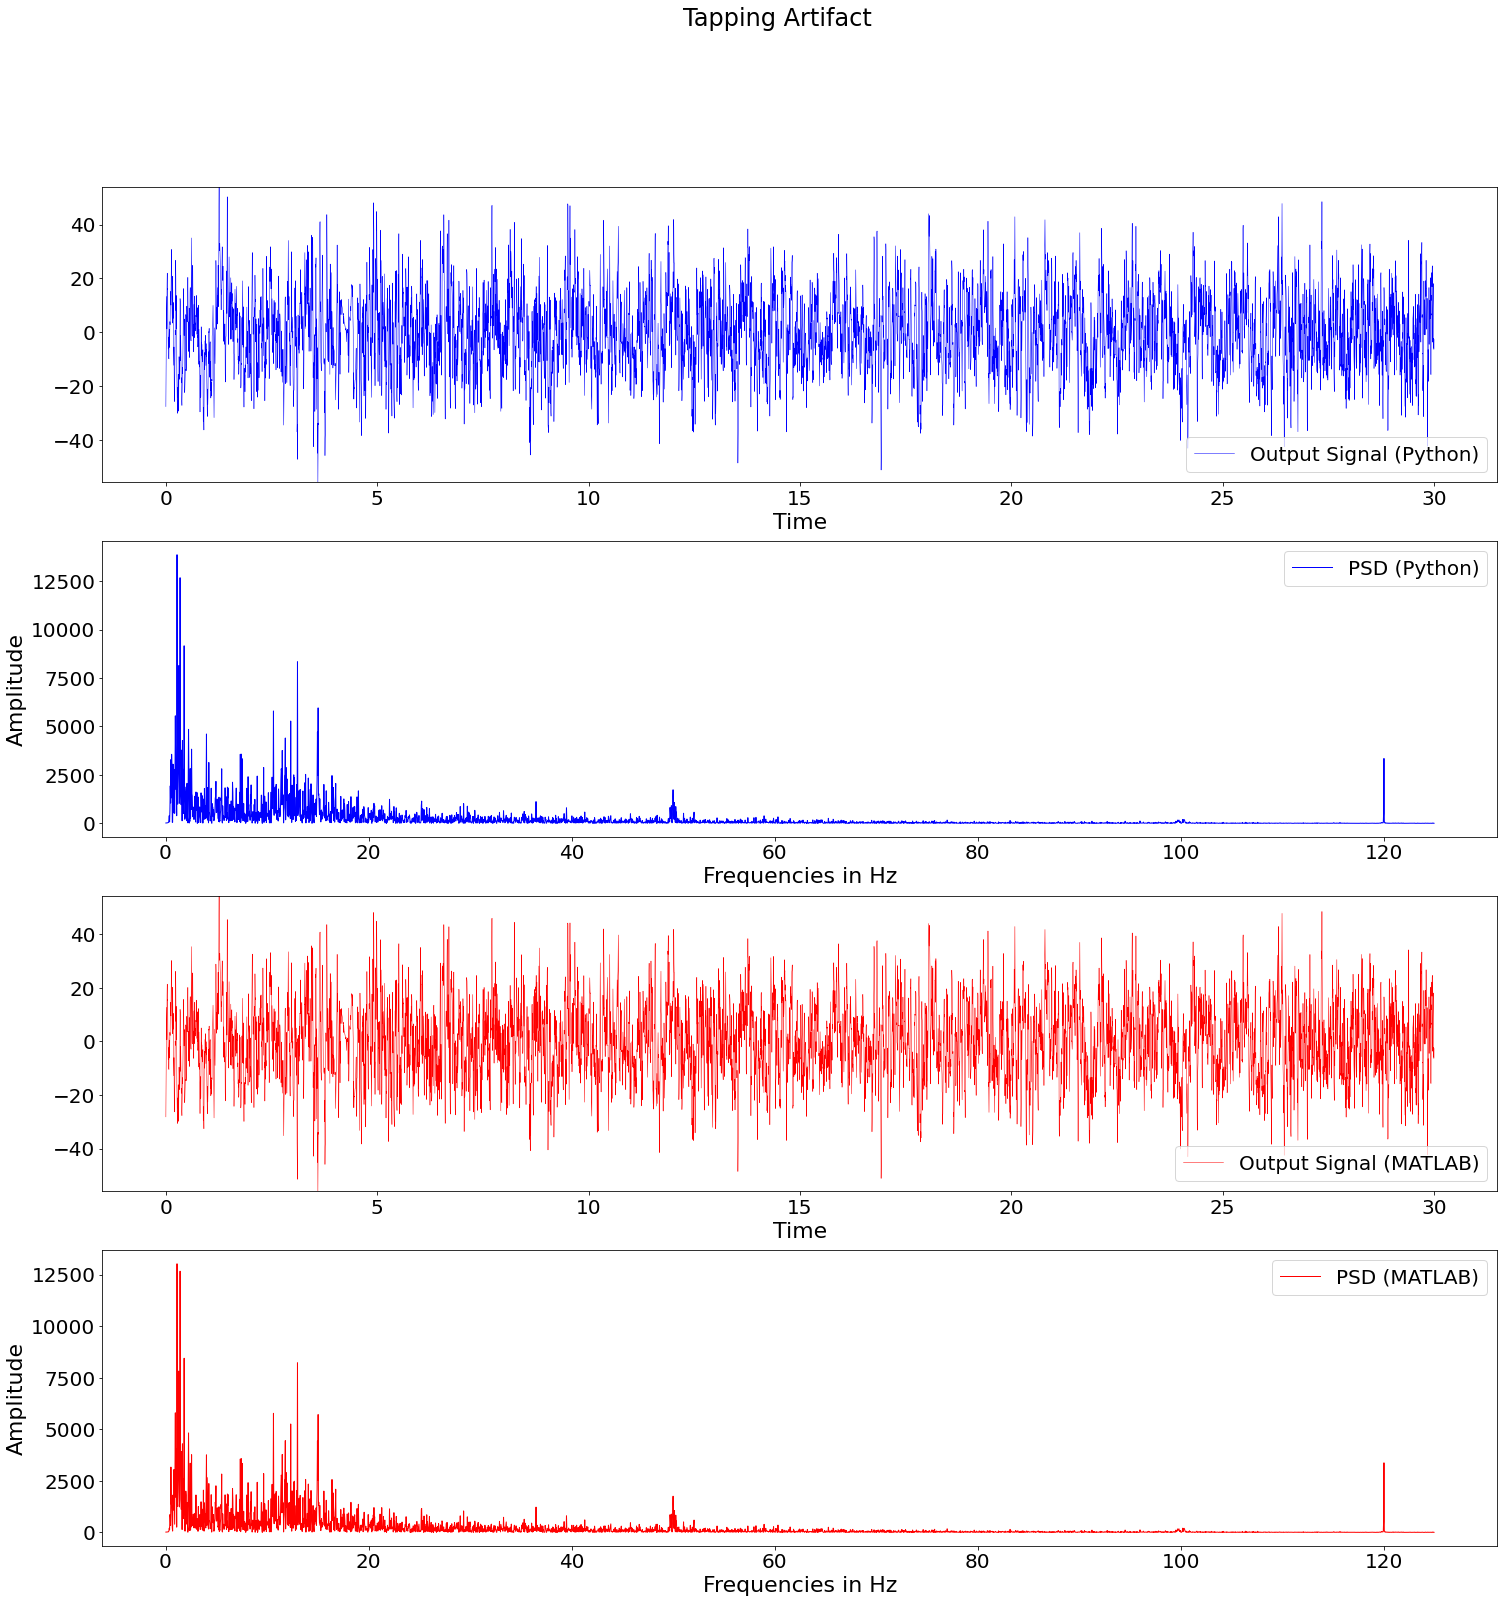

In [14]:
# Plotting both results
fig, ax = plt.subplots(4,1)
plt.rcParams['figure.figsize'] = [40, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels 

ax[0].plot(t_tap, ExG_tap_bayes[1], color='b', lw=0.5, label='Output Signal (Python)')
ax[0].set_ylim([ExG_tap_bayes[1].min(), ExG_tap_bayes[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_tap[idxs_half_tap], np.abs(psd_tap_bayes[idxs_half_tap]), color='b', lw=1, label='PSD (Python)')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t_tap, ExG_tap_bayes_m, color='r', lw=0.5, label='Output Signal (MATLAB)')
ax[2].set_ylim([ExG_tap_bayes_m.min(), ExG_tap_bayes_m.max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_tap[idxs_half_tap], np.abs(psd_tap_bayes_m[idxs_half_tap]), color='r', lw=1, label='PSD (MATLAB)')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.suptitle('Tapping Artifact')
plt.show()

#### (ii) Blinking Artifact

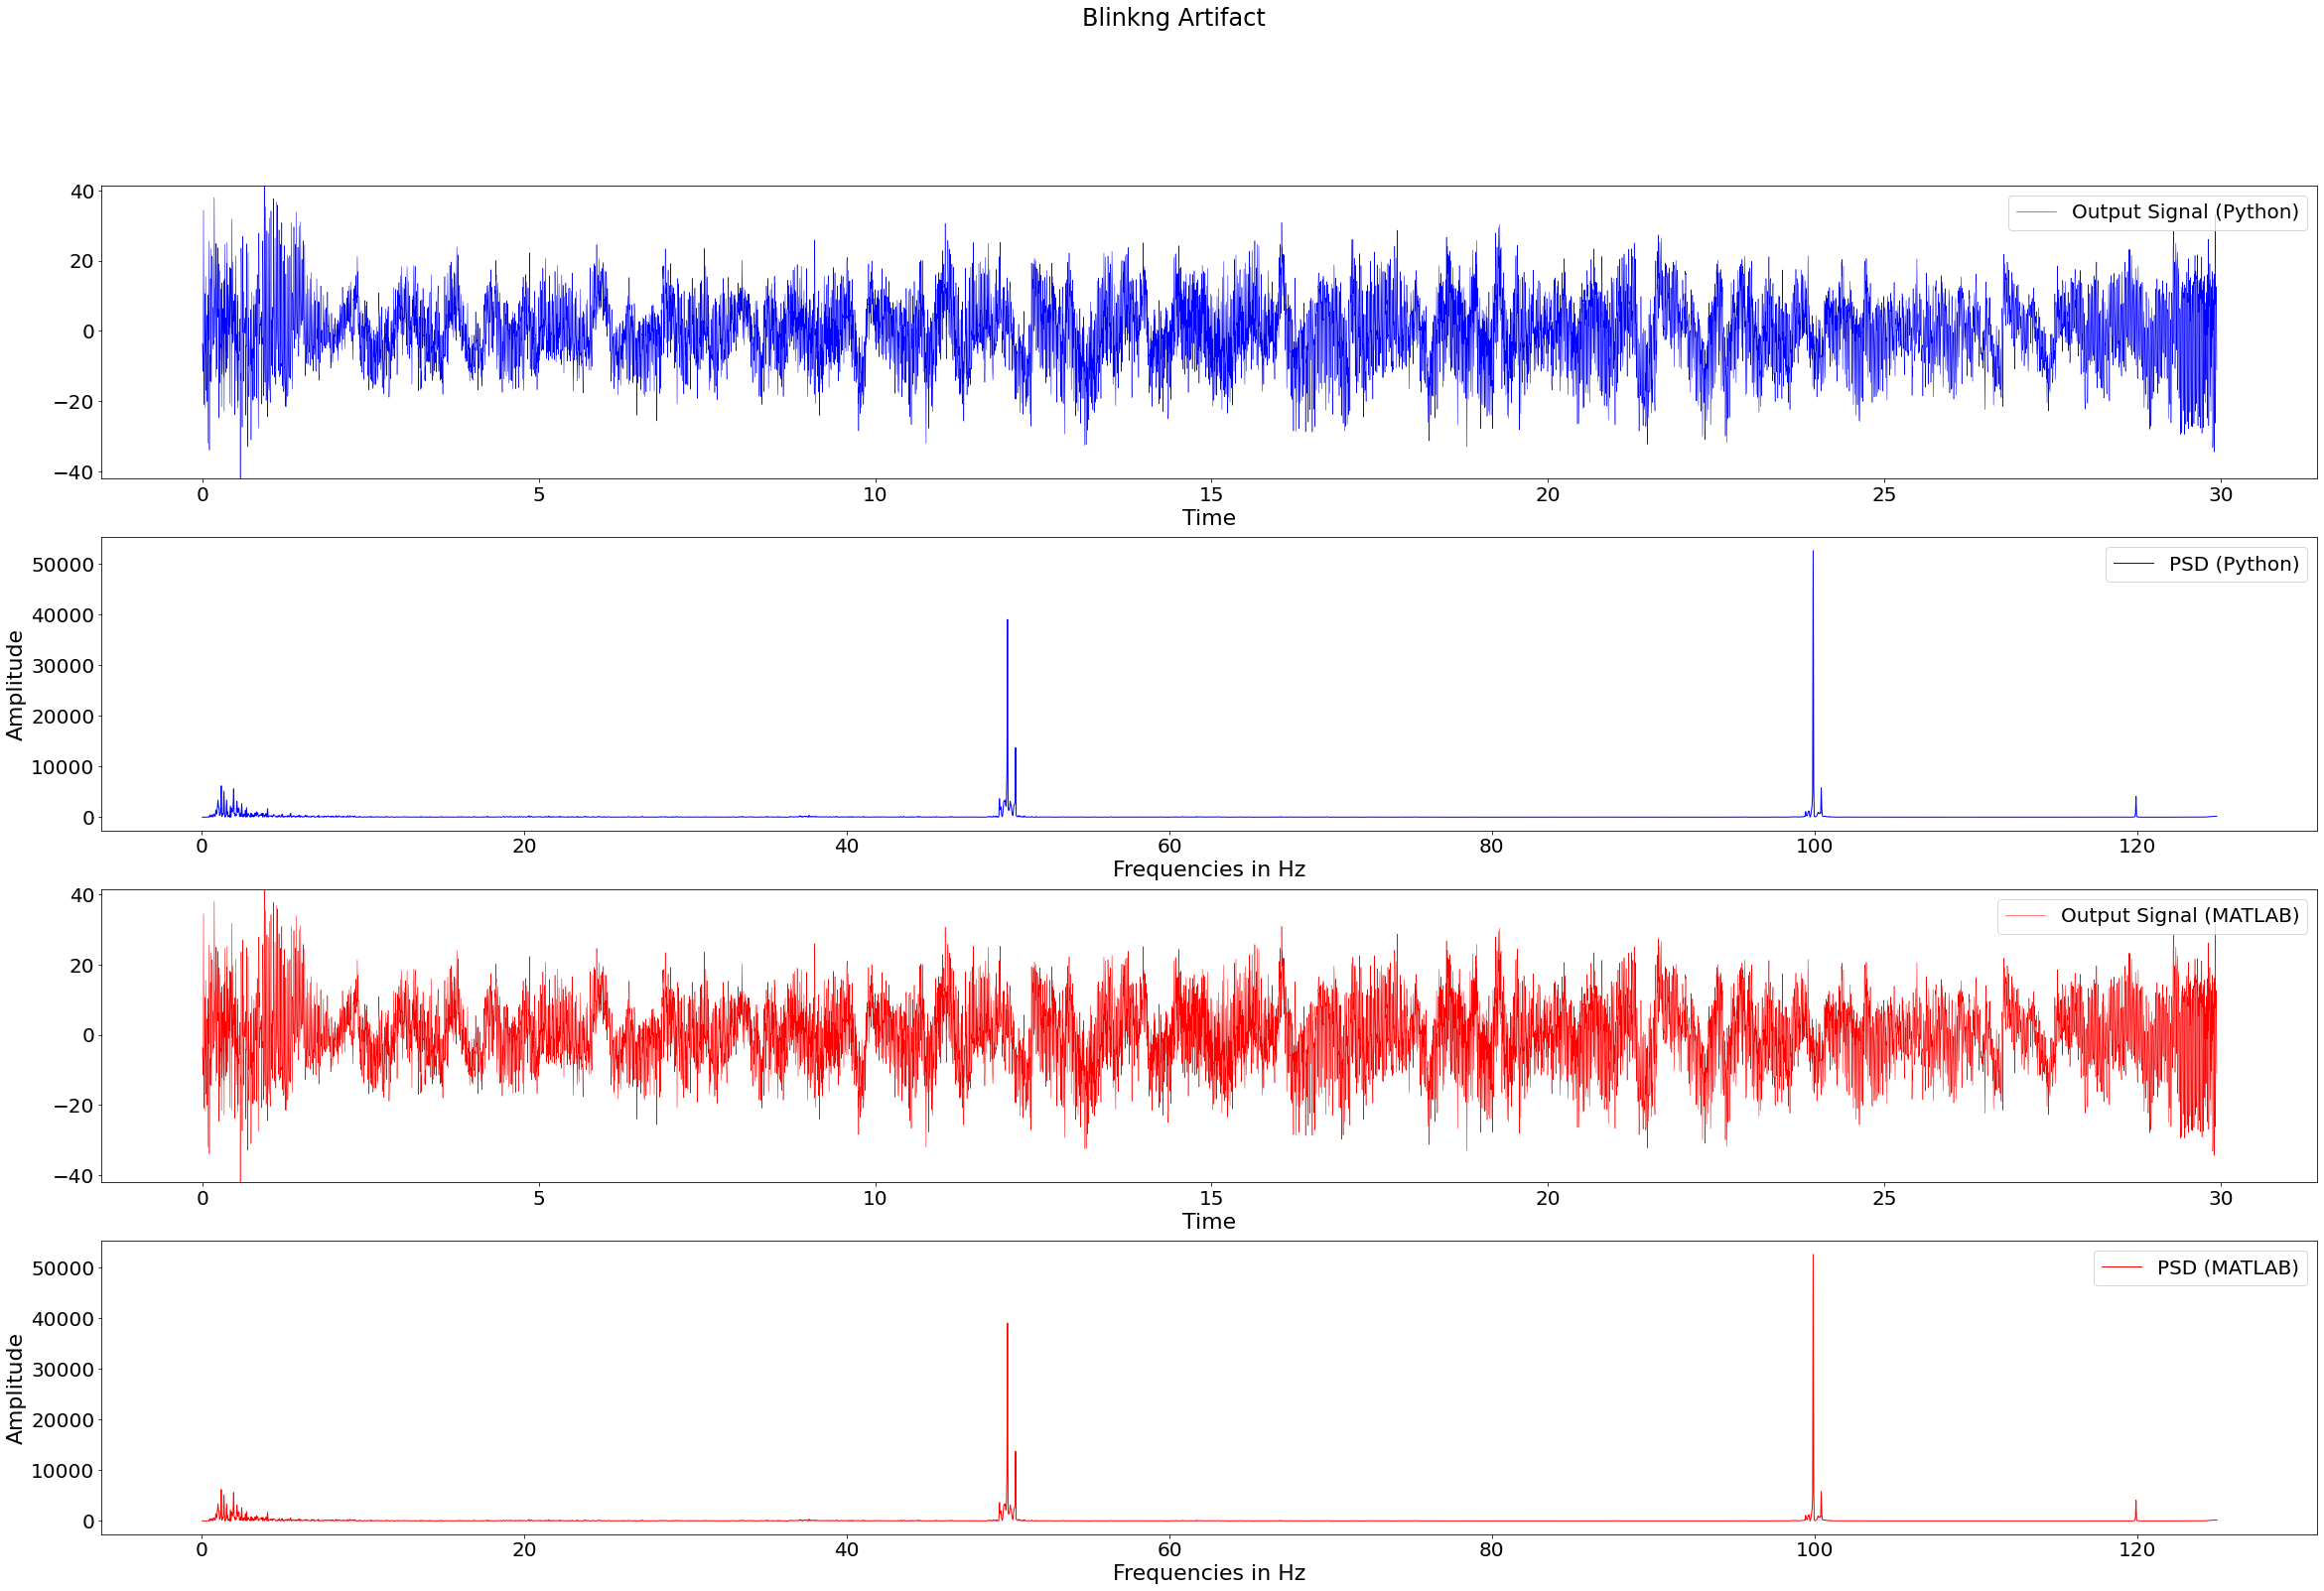

In [15]:
# Plotting both results
fig, ax = plt.subplots(4,1)
plt.rcParams['figure.figsize'] = [40, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels 

ax[0].plot(t_blink, ExG_blink_bayes[1], color='b', lw=0.5, label='Output Signal (Python)')
ax[0].set_ylim([ExG_blink_bayes[1].min(), ExG_blink_bayes[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_blink[idxs_half_blink], np.abs(psd_blink_bayes[idxs_half_blink]), color='b', lw=1, label='PSD (Python)')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t_blink, ExG_blink_bayes_m, color='r', lw=0.5, label='Output Signal (MATLAB)')
ax[2].set_ylim([ExG_blink_bayes_m.min(), ExG_blink_bayes_m.max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_blink[idxs_half_blink], np.abs(psd_blink_bayes_m[idxs_half_blink]), color='r', lw=1, label='PSD (MATLAB)')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.suptitle('Blinkng Artifact')
plt.show()

#### (iii) Movement Artifact

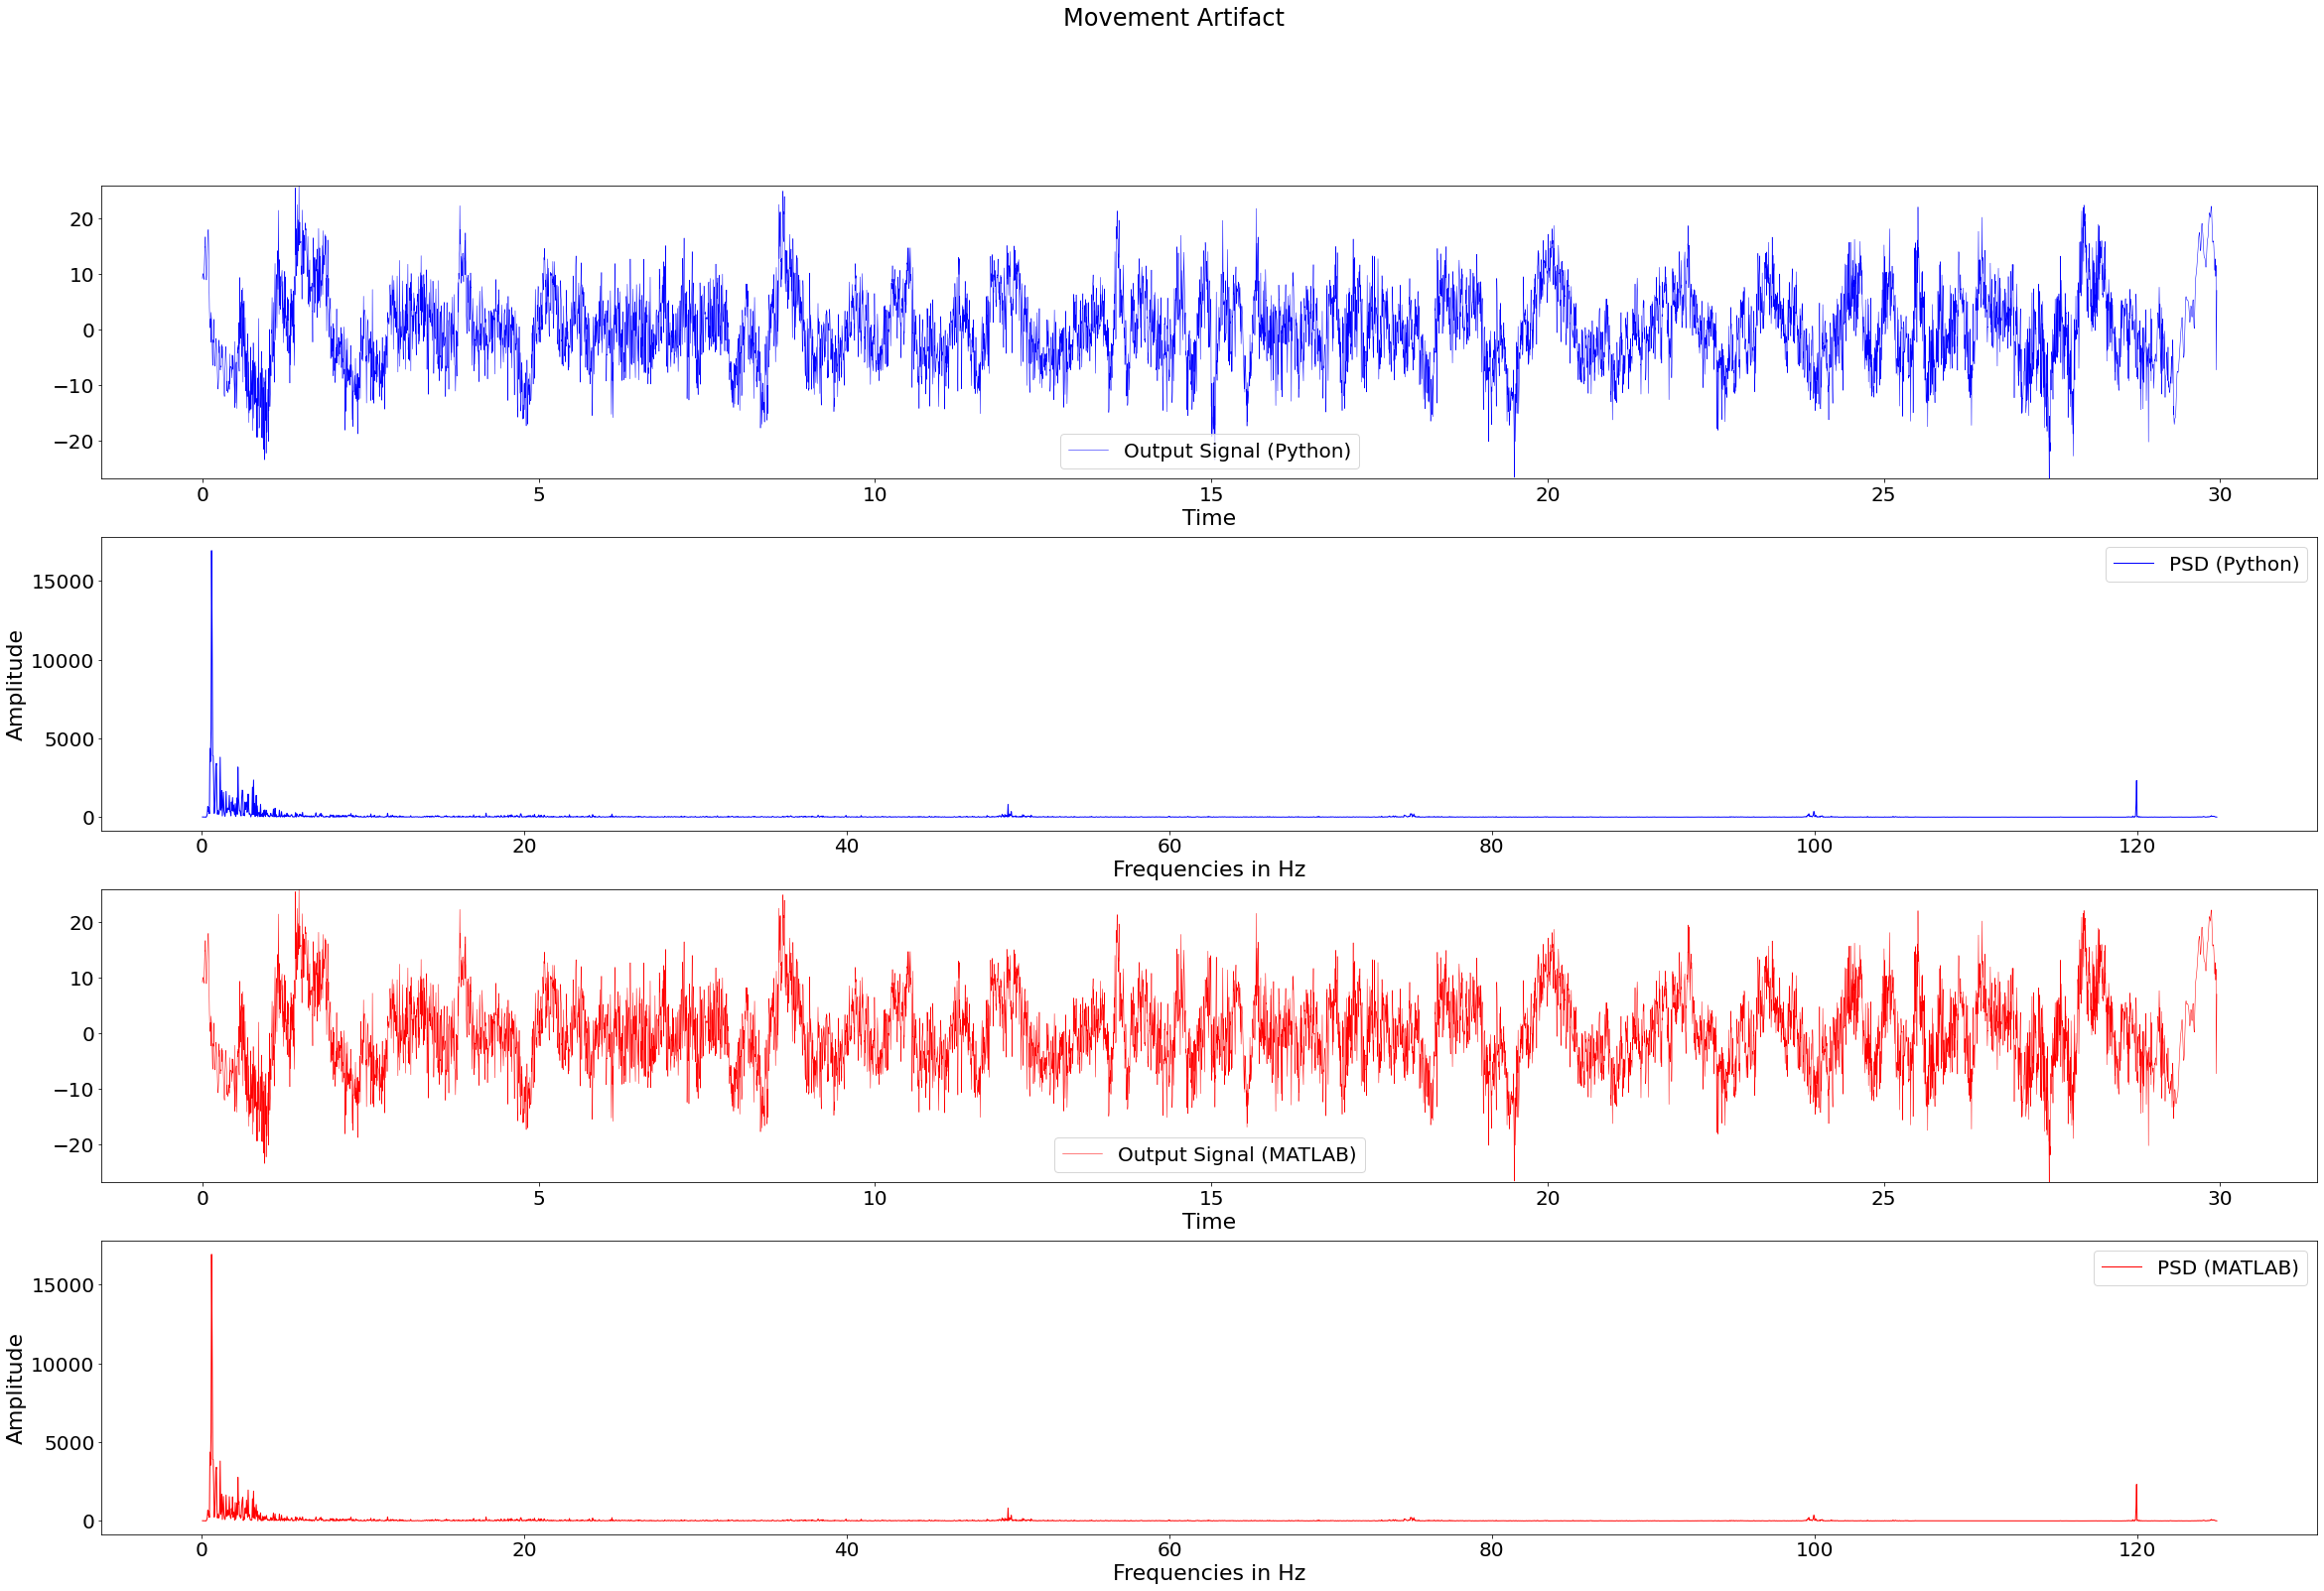

In [16]:
# Plotting both results
fig, ax = plt.subplots(4,1)
plt.rcParams['figure.figsize'] = [40, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels 

ax[0].plot(t_mov, ExG_mov_bayes[1], color='b', lw=0.5, label='Output Signal (Python)')
ax[0].set_ylim([ExG_mov_bayes[1].min(), ExG_mov_bayes[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_mov[idxs_half_mov], np.abs(psd_mov_bayes[idxs_half_mov]), color='b', lw=1, label='PSD (Python)')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t_mov, ExG_mov_bayes_m, color='r', lw=0.5, label='Output Signal (MATLAB)')
ax[2].set_ylim([ExG_mov_bayes_m.min(), ExG_mov_bayes_m.max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_mov[idxs_half_mov], np.abs(psd_mov_bayes_m[idxs_half_mov]), color='r', lw=1, label='PSD (MATLAB)')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.suptitle('Movement Artifact')
plt.show()

### b. Universal Thresholding

In [17]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Universal threshold
def get_level_thd(level_coef: np.array):
    """
    Calculates the threshold value for each wavelet level  

    Args:
        level_coef: a numpy array containing the coefficients for the current level
    Returns:
        level_thd   : a threshold value for the current level
    """
    level_median = np.median(np.abs(level_coef))
    n = len(level_coef)
    level_thd = (level_median/0.75) * np.sqrt(2*np.log(n))
    return level_thd



# 1. Wavelet transform
wavLvl = 8
coef = pywt.wavedecn(ExG_tap_lpf[1, :], 
                        wavelet='coif4', 
                        level=wavLvl,
                        axes=0)

# 2. Determining threshold values for each level
level_thds = []
for level in range(1, wavLvl+1, 1): 
    get_data = coef[level].get("d") 
    level_thd = get_level_thd(get_data)
    level_thds.append(level_thd)

# 3. Thresholding: hard thresholding
coef_artifacts = []
coef_artifacts.append(coef[0])
for level in range(1, wavLvl+1, 1):
    tmp = {"d":  pywt.threshold(coef[level].get("d"), 
                                level_thds[level-1],
                                mode='hard')}
    coef_artifacts.append(tmp)

# 4. Reconstruct data
artifacts = pywt.waverecn(coef_artifacts, 'coif4')

ExG_univ = ExG_tap_lpf[1, :] - artifacts[:ExG_tap_lpf.shape[1]]
#       Computing Fourier Transform
t = ExG_tap[0]
n = len(t)
fhat_univ = np.fft.fft(ExG_univ)
psd_univ = fhat_univ * np.conj(fhat_univ)/n


Normalized cross correlation: [0.9131976]


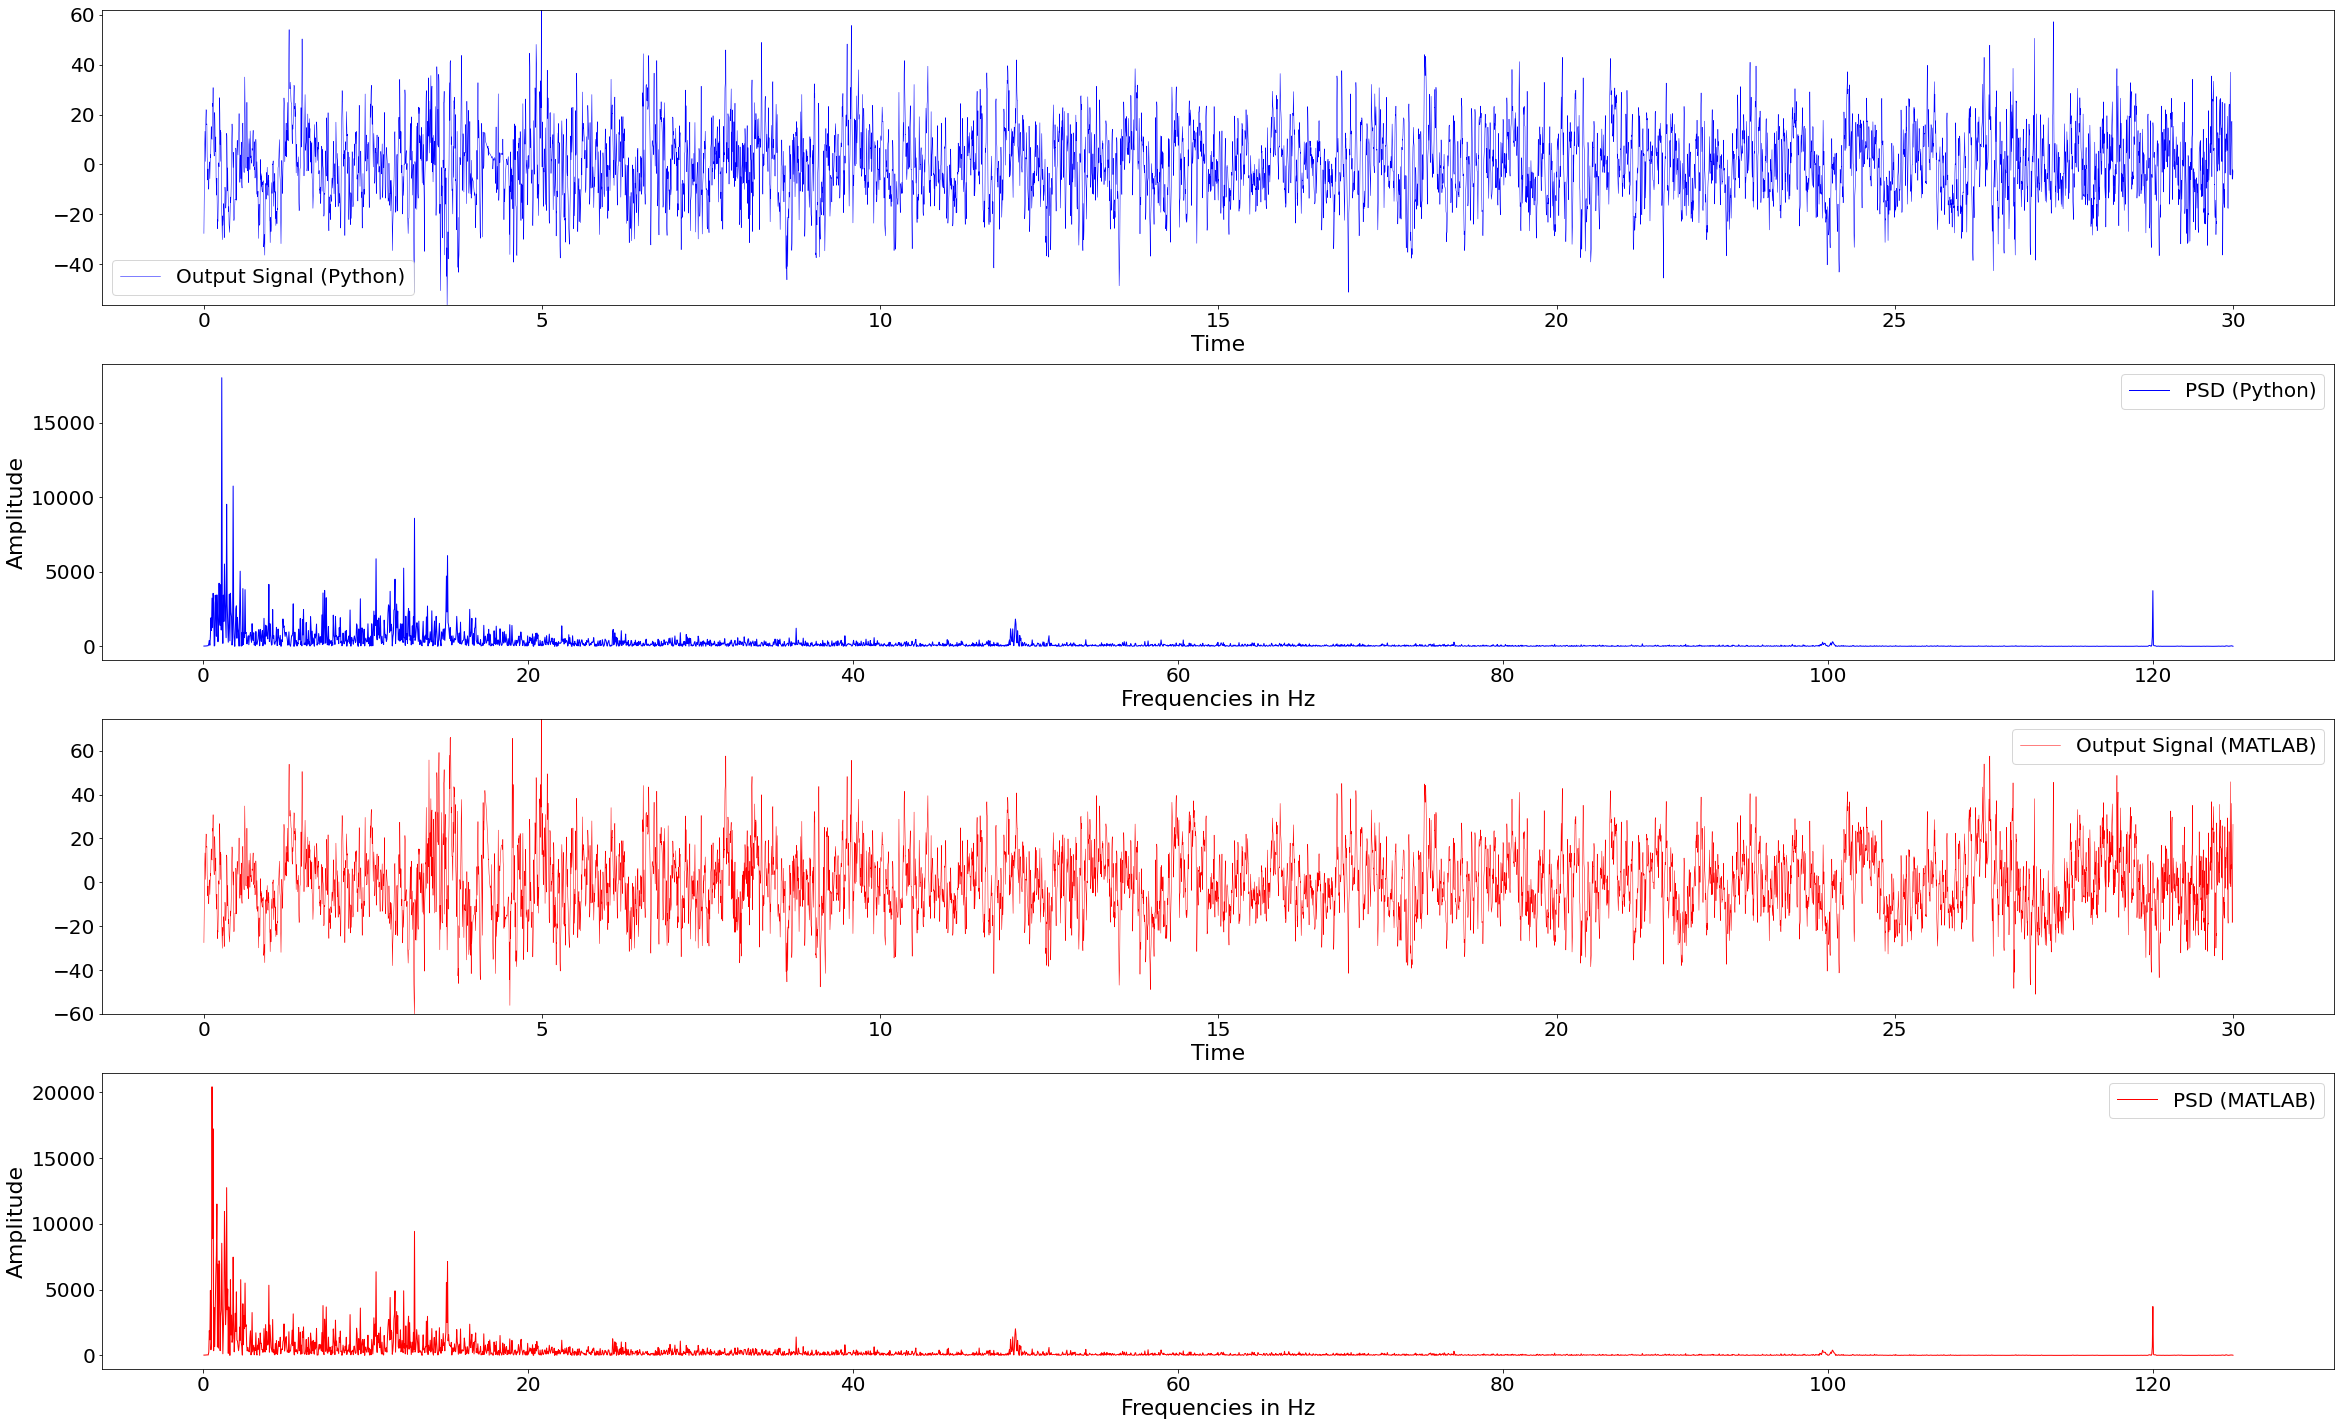

In [18]:
# Reading in results from MATLAB
ExG_univ_m = np.transpose( np.genfromtxt("ExG_univ_m.csv", delimiter = ',') )
#       Computing Fourier Transform
t = ExG_tap[0]
n = len(t)
fhat_univ_m = np.fft.fft(ExG_univ_m)
psd_univ_m = fhat_univ_m * np.conj(fhat_univ_m)/n

# Comparing both results by normalized cross correlation
ExG_univ_norm = (ExG_univ - np.mean(ExG_univ)) / (np.std(ExG_univ) * len(ExG_univ))
ExG_univ_m_norm = (ExG_univ_m - np.mean(ExG_univ_m)) / (np.std(ExG_univ_m))
c = np.correlate(ExG_univ_norm, ExG_univ_m_norm)
print("Normalized cross correlation:", c)

# Plotting both results
fig, ax = plt.subplots(4,1)
plt.rcParams['figure.figsize'] = [40, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels 

ax[0].plot(t, ExG_univ, color='b', lw=0.5, label='Output Signal (Python)')
ax[0].set_ylim([ExG_univ.min(), ExG_univ.max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq_tap[idxs_half_tap], np.abs(psd_univ[idxs_half_tap]), color='b', lw=1, label='PSD (Python)')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t, ExG_univ_m, color='r', lw=0.5, label='Output Signal (MATLAB)')
ax[2].set_ylim([ExG_univ_m.min(), ExG_univ_m.max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq_tap[idxs_half_tap], np.abs(psd_univ_m[idxs_half_tap]), color='r', lw=1, label='PSD (MATLAB)')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()
plt.show()